# Setup

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from typing import Literal
from warnings import warn
import string
import re
import random
from random import choice
import json
from typing import Literal, Union
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 6)

# Set default font size for x and y labels
plt.rcParams['axes.labelsize'] = 18

# Set default font size for ticks
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 18.5

# Set default font size for title
plt.rcParams['axes.titlesize'] = 18

# Legend font size
plt.rcParams['legend.fontsize'] = 18

In [4]:
! pip install faiss-gpu-cu12
! pip install -q datasets
! pip install -q langchain-ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5

In [5]:
import faiss
import langchain_ollama
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate
from datasets import load_dataset

In [6]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
project_path= '/content/drive/MyDrive/P10- RAG-GAS/'
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
!sudo apt -q update > /dev/null 2>&1
!sudo apt install -y -q pciutils > /dev/null 2>&1
!curl -q -fsSL https://ollama.com/install.sh | sh > /dev/null 2>&1

In [ ]:
# Run this after keyboard interupts to re-start model generation.
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def _compute_metrics(y_true, y_pred):

    # Ottieni gli indici dove y_pred è un valore booleano
    _to_evaluate = [i for i, val in enumerate(y_pred) if isinstance(val, bool)]

    # Filtra y_true e y_pred utilizzando gli indici
    y_true_filtered = [bool(y_true[i]) for i in _to_evaluate]
    y_pred_filtered = [(y_pred[i]) for i in _to_evaluate]

    # Calculate precision, recall, and F1 score for each class
    p, r, f, _ = precision_recall_fscore_support(y_true_filtered, y_pred_filtered, average=None, zero_division=0)

    # Handle missing values if there are no positive or negative labels in the data
    p_pos = p[1] if len(p) > 1 else 0  # Positive class precision
    r_pos = r[1] if len(r) > 1 else 0  # Positive class recall
    f_pos = f[1] if len(f) > 1 else 0  # Positive class F1 score
    p_neg = p[0] if len(p) > 0 else 0  # Negative class precision
    r_neg = r[0] if len(r) > 0 else 0  # Negative class recall
    f_neg = f[0] if len(f) > 0 else 0  # Negative class F1 score

    # Calculate the averages
    avg_p = (p_pos + p_neg) / 2
    avg_r = (r_pos + r_neg) / 2
    avg_f1 = (f_pos + f_neg) / 2

    return {
        'Avg(P)': avg_p,
        'Avg(R)': avg_r,
        'Avg(F1)': avg_f1,
        'P(+)': p_pos,
        'R(+)': r_pos,
        'F1(+)': f_pos,
        'P(-)': p_neg,
        'R(-)': r_neg,
        'F1(-)': f_neg,
    }

In [ ]:
!ollama pull mistral >> /dev/null 2>&1

In [ ]:
! ollama pull llama3.2 >> /dev/null 2>&1

In [ ]:
! ollama pull llama2:13b >> /dev/null 2>&1

In [ ]:
def compute_avgf1(y_true, y_pred):
  return _compute_metrics(y_true, y_pred)['Avg(F1)']

## Retrieval-System

In [7]:
class RetrievalSystem:

  def __init__(
      self,
      db : pd.DataFrame,
      embedding_model_name : str,
      lang = 'eng',
  ):
    # DB
    self.db = db
    self.db_positive = db[db['Successful']]
    self.db_negative = db[~db['Successful']]

    # Instantiate embedding model
    print(f"Instantiating embedding model: {embedding_model_name}")
    self.embedding_model_name = embedding_model_name
    self.embedding_model = SentenceTransformer(self.embedding_model_name,trust_remote_code=True)
    self._summary_name = "Summary" if lang == 'eng' else lang + "_Summary"

    self._set_up_semantic_search()

    print("System created.")

  def _set_up_semantic_search(self):
    # Set-up for semantic search
    self.pos_embeddings= {}
    self.neg_embeddings= {}
    self.embeddings= {}

    self.pos_index= {}
    self.neg_index= {}
    self.index= {}

    ## Generate embeddings
    print("Generating embeddings")
    ### Not Scaled
    self.pos_embeddings['not_scaled'] = self.embedding_model.encode(self.db_positive[self._summary_name].tolist())
    self.neg_embeddings['not_scaled'] = self.embedding_model.encode(self.db_negative[self._summary_name].tolist())
    self.embeddings['not_scaled'] = self.embedding_model.encode(self.db[self._summary_name].tolist())
    ### Scaled
    print("Scaling embeddigs...")
    self.pos_embeddings['scaled'] = self.pos_embeddings['not_scaled'].copy()
    self.neg_embeddings['scaled'] = self.neg_embeddings['not_scaled'].copy()
    self.embeddings['scaled'] = self.embeddings['not_scaled'].copy()
    faiss.normalize_L2(self.pos_embeddings['scaled'])
    faiss.normalize_L2(self.neg_embeddings['scaled'])
    faiss.normalize_L2(self.embeddings['scaled'])

    ## Instantiate FAISS indexes
    ### For IP
    print("Creating indexing for IP")
    self.pos_index['IP'] = faiss.IndexFlatIP(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['IP'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['IP'] = faiss.IndexFlatIP(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['IP'].add(self.neg_embeddings['not_scaled'])
    self.index['IP'] = faiss.IndexFlatIP(self.embeddings['not_scaled'].shape[1])
    self.index['IP'].add(self.embeddings['not_scaled'])


    ### For Cosine similarity
    print("Creating indexing for COS")
    self.pos_index['COS'] = faiss.IndexFlatIP(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['COS'].add(self.pos_embeddings['scaled'])
    self.neg_index['COS'] = faiss.IndexFlatIP(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['COS'].add(self.neg_embeddings['scaled'])
    self.index['COS'] = faiss.IndexFlatIP(self.embeddings['scaled'].shape[1])
    self.index['COS'].add(self.embeddings['scaled'])

    ### For L2-not_scaled
    print("Creating indexing for L2-NOT-SCALED")
    self.pos_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['not_scaled'].shape[1])
    self.pos_index['L2-NOT-SCALED'].add(self.pos_embeddings['not_scaled'])
    self.neg_index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['not_scaled'].shape[1])
    self.neg_index['L2-NOT-SCALED'].add(self.neg_embeddings['not_scaled'])
    self.index['L2-NOT-SCALED'] = faiss.IndexFlatL2(self.embeddings['not_scaled'].shape[1])
    self.index['L2-NOT-SCALED'].add(self.embeddings['not_scaled'])

    ### For L2-scaled
    print("Creating indexing for L2-SCALED")
    self.pos_index['L2-SCALED'] = faiss.IndexFlatL2(self.pos_embeddings['scaled'].shape[1])
    self.pos_index['L2-SCALED'].add(self.pos_embeddings['scaled'])
    self.neg_index['L2-SCALED'] = faiss.IndexFlatL2(self.neg_embeddings['scaled'].shape[1])
    self.neg_index['L2-SCALED'].add(self.neg_embeddings['scaled'])
    self.index['L2-SCALED'] = faiss.IndexFlatL2(self.embeddings['scaled'].shape[1])
    self.index['L2-SCALED'].add(self.embeddings['scaled'])


  @staticmethod
  def _filter_and_limit(similarity, indices, upper_bound, lower_bound):

      if upper_bound is not None:
          mask = similarity <= upper_bound
          similarity = similarity[mask]
          indices = indices[mask]

      if lower_bound is not None:
          mask = similarity >= lower_bound
          similarity = similarity[mask]
          indices = indices[mask]

      return similarity, indices

  def retrieve(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      """
      Retrieve examples from memory based on similarity to the query.
      Args:
          query (str): The query summary to retrieve examples for.
          top_k (int): The number of examples to retrieve.
          split (bool): Whether to use separate positive and negative indices.
          upper_bound (float): maximum similarity score.
          lower_bound (float): minimum similarity score

      Returns:
          pd.DataFrame: A DataFrame of the retrieved examples with a 'distance' column.
      """
      query_embedding = self.embedding_model.encode([query])
      if metric in ['COS','L2-SCALED']:
        faiss.normalize_L2(query_embedding)

      if not split:
          metric_score, indices = self.index[metric].search(query_embedding, top_k)
          metric_score, indices = RetrievalSystem._filter_and_limit(metric_score[0], indices[0], upper_bound=upper_bound,lower_bound=lower_bound)
          retrieved_df = self.db.iloc[indices].copy()
          retrieved_df[metric] = metric_score

      else:
          metric_score_pos, indices_pos = self.pos_index[metric].search(query_embedding, top_k)
          metric_score_neg, indices_neg = self.neg_index[metric].search(query_embedding, top_k)

          metric_score_pos, indices_pos = RetrievalSystem._filter_and_limit(metric_score_pos[0], indices_pos[0], upper_bound=upper_bound,lower_bound=lower_bound)
          metric_score_neg, indices_neg = RetrievalSystem._filter_and_limit(metric_score_neg[0], indices_neg[0], upper_bound=upper_bound,lower_bound=lower_bound)

          pos_retrieved = self.db_positive.iloc[indices_pos].copy()
          pos_retrieved[metric] = metric_score_pos

          neg_retrieved = self.db_negative.iloc[indices_neg].copy()
          neg_retrieved[metric] = metric_score_neg

          retrieved_df = pd.concat([pos_retrieved, neg_retrieved])

      return retrieved_df.sort_values(by=metric, ascending = True if 'L2' in metric else False)

  def __call__(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound : float = None,
        lower_bound : float = None,
        metric : str = 'IP'
  ) -> pd.DataFrame:
      return self.retrieve(query,top_k,split,upper_bound,lower_bound,metric)

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

class RetrievalSystemSparse:

    def __init__(
        self,
        db: pd.DataFrame,
        vectorizer_type: str = "bow",
        lang="eng",
    ):
        """
        Retrieval system using sparse vector representations.

        Args:
            db (pd.DataFrame): Database containing the examples with a 'Summary' and 'Successful' column.
            vectorizer_type (str): Type of vectorizer to use ('tfidf' or 'bow').
            lang (str): Language to determine the column name for 'Summary'.
        """
        self.db = db
        self.vectorizer_type = vectorizer_type
        self._summary_name = "Summary" if lang == "eng" else lang + "_Summary"

        # Initialize vectorizer
        if vectorizer_type == "tfidf":
            self.vectorizer = TfidfVectorizer()
        elif vectorizer_type == "bow":
            self.vectorizer = CountVectorizer(binary=True)
        else:
            raise ValueError("Unsupported vectorizer type. Use 'tfidf' or 'bow'.")

        print(f"Instantiating {vectorizer_type.upper()} vectorizer")

        # Fit vectorizer and create representations
        print("Fitting vectorizer and generating sparse representations...")
        self.sparse_embeddings = self.vectorizer.fit_transform(self.db[self._summary_name])

        # Initialize NearestNeighbors
        print("Creating NearestNeighbors model...")
        self.nn_model = NearestNeighbors(metric="cosine")
        self.nn_model.fit(self.sparse_embeddings)

        print("Sparse retrieval system created.")

    def retrieve(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound: float = None,
        lower_bound: float = None,
        metric: str = "cosine",
    ) -> pd.DataFrame:
        """
        Retrieve examples from memory based on similarity to the query.

        Args:
            query (str): The query summary to retrieve examples for.
            top_k (int): The number of examples to retrieve.
            split (bool): Ignored for sparse retrieval; included for compatibility.
            upper_bound (float): Maximum similarity score (ignored for now).
            lower_bound (float): Minimum similarity score (ignored for now).
            metric (str): Similarity metric (only 'cosine' is supported).

        Returns:
            pd.DataFrame: A DataFrame of the retrieved examples with a 'distance' column.
        """
        if metric != "cosine":
            raise ValueError("Sparse retrieval currently only supports 'cosine' metric.")

        # Transform query
        query_embedding = self.vectorizer.transform([query])

        # Retrieve nearest neighbors
        distances, indices = self.nn_model.kneighbors(query_embedding, n_neighbors=top_k)

        # Create DataFrame for results
        retrieved_df = self.db.iloc[indices[0]].copy()
        retrieved_df["distance"] = distances[0]

        return retrieved_df.sort_values(by="distance", ascending=True)

    def __call__(
        self,
        query: str,
        top_k: int,
        split: bool,
        upper_bound: float = None,
        lower_bound: float = None,
        metric: str = "cosine",
    ) -> pd.DataFrame:
        return self.retrieve(query, top_k, split, upper_bound, lower_bound, metric)


In [9]:
class RAC:
    """
    Given a `Retrieval System`, this class is used to label points according to one out of four policies : `knn`,`weighted-knn`,`rarity` and `sampling`.
    - `knn`: labels (+) or (-) according to a majority vote scheme
    - `weighted-knn`: same as `knn`, but votes are scaled by distance (i.e. the farther the less important, the closer the more important).
    - `rarity`: this modality has the role of demostrating that our DB is to crowded of (-) examples, reducing the potentiality of the model. This modality scales both (+) and (-)  according to label frequency in DB. It is equivalent to label a query q positive whenever a positive element is retrieved among the k-nearest-neighbors as far as k < $\frac{1}{|DB|}$, (k < 94 while the whole DB is used)
    - `Sampling`: computes a pdf through softmax using as weights the inverse of the distance squared. A sample is sampled from the neighborhood according such pdf, and its label is then assigned to the query q.
    """
    _EPS=1e-12
    policies = ['knn','weighted-knn','sampling','rarity']

    def __init__(
        self,
        retrieval_system : RetrievalSystem,
    ):
      self.retrieval_system = retrieval_system
      self._pos_rarity = self.retrieval_system.db_positive.shape[0] / self.retrieval_system.db.shape[0]
      self._neg_rarity = self.retrieval_system.db_negative.shape[0] / self.retrieval_system.db.shape[0]
      self.rarity_map = {True : 1 / self._pos_rarity, False : 1/ self._neg_rarity}

    @staticmethod
    def _knn(neighborhood : pd.DataFrame):
      return neighborhood['Successful'].mode()[0]

    @staticmethod
    def _weighted_knn(neighborhood : pd.DataFrame, metric : str, rarity_rescale : bool, rarity_map : dict = None):
      # Weight
      if metric in ['IP', 'COS']:
        w = neighborhood[metric]
      elif 'L2' in metric :
        w = 1 / (neighborhood[metric] + RAC._EPS)
      else :
        raise ValueError(f"Metric {metric} not defined")

      # Rarity Rescaling
      if rarity_rescale:
        w = neighborhood[metric] * neighborhood['Successful'].map(rarity_map)

      # Votes
      _pos_votes = sum(w * neighborhood['Successful'])
      _neg_votes = sum(w * ~neighborhood['Successful'])

      if _pos_votes > _neg_votes:
        label = True
      elif _pos_votes < _neg_votes:
        label = False
      else:
        # Random
        label = choice([_pos_votes,_neg_votes])

      return label

    @staticmethod
    def _sampling(neighborhood : pd.DataFrame, metric : str):

      # Compute Weights
      if metric == 'IP':
        # Avoids exploding
        neighborhood[metric]= neighborhood[metric] / (neighborhood[metric].sum() + RAC._EPS)

      if 'L2' in metric:
        # Distance-based behaves conversely
        neighborhood[metric] = -neighborhood[metric]

      # Individual contribute to the prob. distribution
      _input_vectors = np.exp(neighborhood[metric])

      # Softmax
      neighborhood['p'] = _input_vectors / (np.sum(_input_vectors) + RAC._EPS)

      # Sample
      labeler = neighborhood.sample(n=1,weights = 'p').iloc[-1]

      # Label
      label = labeler['Successful']

      return label

    def classify(
        self,
        query : str,
        policy : str,
        metric : str = 'IP',
        *args,
        **kwargs,
    ) -> bool:

      if policy not in RAC.policies:
        raise ValueError(f"{policy} not available. Please choose among: {RAC.policies}")

      # Retreive
      neighborhood = self.retrieval_system(query,split=False, metric = metric, **kwargs)

      if policy == 'knn':
        # Majority Vote
        label = RAC._knn(neighborhood)

      if policy == "weighted-knn":
        label = RAC._weighted_knn(neighborhood,metric,rarity_rescale=False)

      if policy == 'rarity':
        label = RAC._weighted_knn(neighborhood,metric,rarity_rescale=True,rarity_map = self.rarity_map)

      if policy == 'sampling':
        label = RAC._sampling(neighborhood,metric)

      return label

    def __call__(
        self,
        query : str,
        policy : str,
        metric : str = 'IP',
        *args,
        **kwargs,
    ) -> bool:
      return self.classify(query,policy,metric,*args,**kwargs)


## RAG

In [ ]:
class RAG:

  def __init__(self,retrieval_system: Union[RetrievalSystem, RetrievalSystemSparse],model_name : str,**kwargs):
    self.retrieval_system = retrieval_system
    self.model_name = model_name
    self.model = OllamaLLM(model=model_name,**kwargs)

  @staticmethod
  def _normalize(resp : str):
    _r = resp.strip().strip("\n").strip('.').upper()
    if "YES" in _r:
      return True
    if ( "NO" in _r) or ("NOT" in _r):
      return False
    else:
      # Split in words
      answer = _r.split()[0]
      answer = answer.strip().translate(str.maketrans('', '', string.punctuation)).upper()
      if answer == "YES":
        return True
      if (answer == "NO") or (answer == "NOT"):
        return False

    warn(f"The answer {resp} does not match neither YES nor NO.")
    return resp

  @staticmethod
  def print_prompt(template,description,examples,k = -1 ,true_count = -1 ,false_count= -1):
    print(template.format(
        description=description,
        examples=examples,
        k=k,
        true_count=true_count,
        false_count=false_count
    ))

  def generate(
      self,
      query : str,
      prompt_template : str,
      example_template: str,
      print_prompt : bool = False,
      **kwargs
  ) -> str:

    # Retrieve
    neighborhood = self.retrieval_system(query,**kwargs)

    # Format examples
    examples = "\n".join(
        example_template.format(
            i=index + 1,
            description=r[self.retrieval_system._summary_name],
            label="YES" if r['Successful'] else "NO")
        for index, (_,r) in enumerate(neighborhood.iterrows()))

    # Create Prompt and chain
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | self.model

    if print_prompt:
      RAG.print_prompt(prompt_template,query,examples)

    # Ask the model
    invoke_dict = {
        'examples':examples,
        'description':query,
        'k': kwargs.get('top_k'),
        'true_count': f"{neighborhood['Successful'].sum()}",
        'false_count' :f"{(~neighborhood['Successful']).sum()}"
      }

    # Ask the model
    return chain.invoke(invoke_dict)

  def __call__(
        self,
        query : str,
        prompt_template : str,
        example_template: str,
        print_prompt : bool = False,
        **kwargs
    ) -> str:
      return RAG._normalize(
          self.generate(query,prompt_template,example_template,print_prompt,**kwargs)
      )

# DATA: Loading, Analysis, Exploration.

In [10]:
# Read Data
data = pd.read_csv('data_eng.csv').drop(['Unnamed: 0','Repair_Code','Performed_By','Repair_Image','Damage_Image','Kit_Size_str','Pipe_Size','Kit_Compliance'],axis = 1)

In [11]:
data_positive = data[data['Successful']]
data_negative = data[~data['Successful']]

In [14]:
## Example (+)
print(f"[+]: {data_positive.iloc[3]['Summary']}")
## Example (-)
print(f"[-]:  {data_negative.iloc[3]['Summary']}")

[+]: A non-sheared linear lesion has developed on a steel pipe at user connections due to poor conditions. No strong corrosion is present, and high pressure within the pipe is false. Additionally, there are no ribs or branches near the break, and the pipe is not covered by a wall. Finally, a valve is not located near the break.
[-]:  The aerial steel pipe exhibits severe strong corrosion and bad conditions, leading to a non-sheared linear lesion. The high pressure within the pipe contributes to the degradation, especially since the branch near the break is true. The pipe is covered by a wall, further aggravating the corrosive effects. However, the presence of a valve near the break is false, and there are no ribs to provide additional support. The fault is likely caused by a combination of factors, including exposure to harsh environmental conditions and inadequate maintenance.


## Exploratory Data Analysis (EDA)


In [ ]:
data.shape

(11904, 15)

In [ ]:
data_positive.shape

(126, 15)

In [ ]:
data_negative.shape

(11778, 15)

## Feature distribution

In [ ]:
import pandas as pd

# Example: Assuming `data` is your dataframe
result = []
for col in data.drop(['ID','Summary','Summary_1'],axis=1).columns:
    if col == 'Successful':  # Skip the 'Successful' column itself
        continue

    # Unique values in the entire column
    all_values = set(data[col].unique())

    # Unique values in each group
    positive_values = set(data[data['Successful'] == True][col].unique())
    negative_values = set(data[data['Successful'] == False][col].unique())

    # Determine the excluded elements
    excluded_positive = all_values - positive_values
    excluded_negative = all_values - negative_values

    # Append the results
    result.append([
        col,
        len(all_values),
        len(positive_values),
        len(negative_values),
        list(excluded_positive) if len(excluded_positive) > 0 else "None",  # Excluded from the positive group
        list(excluded_negative)   # Excluded from the negative group
    ])

# Create the final table
result_df = pd.DataFrame(
    result,
    columns=['Feature', '#UNIQUE VALUES', 'Patchable (+)', 'Not Patchable (-)', 'Values Excluded in (+)', 'Excluded in -']
)
result_df.drop('Excluded in -',axis = 1)
features_with_excluded_values = result_df[result_df['Values Excluded in (+)'] != 'None']
values_excluded = features_with_excluded_values['Values Excluded in (+)'].tolist()

In [ ]:
result_df

Feature  #UNIQUE VALUES  Patchable (+)  Not Patchable (-)  \
0             Kit_Size_num               5              5                  5   
1   Pipe_In_Bad_Conditions               2              2                  2   
2            Pipe_Material               6              6                  6   
3              Damage_Type              11              9                 11   
4            Pipe_Exposure               3              3                  3   
5         Severe_Corrosion               2              1                  2   
6             Pipe_Covered               2              1                  2   
7        Branch_Near_Fault               2              1                  2   
8            High_Pressure               2              1                  2   
9            Damaged_Valve               2              1                  2   
10                    Ribs               2              1                  2   

                               Values Excluded in (+) Excluded in -  
0                                                None            []  
1                                                None            []  
2                                                None            []  
3   [Visible deformation in axial direction, Shear...            []  
4                                                None            []  
5                                              [True]            []  
6                                              [True]            []  
7                                              [True]            []  
8                                              [True]            []  
9                                              [True]            []  
10                                             [True]            []

In [ ]:
features_with_excluded_values

Feature  #UNIQUE VALUES  Patchable (+)  Not Patchable (-)  \
3         Damage_Type              11              9                 11   
5    Severe_Corrosion               2              1                  2   
6        Pipe_Covered               2              1                  2   
7   Branch_Near_Fault               2              1                  2   
8       High_Pressure               2              1                  2   
9       Damaged_Valve               2              1                  2   
10               Ribs               2              1                  2   

                               Values Excluded in (+) Excluded in -  
3   [Visible deformation in axial direction, Shear...            []  
5                                              [True]            []  
6                                              [True]            []  
7                                              [True]            []  
8                                              [True]            []  
9                                              [True]            []  
10                                             [True]            []

In [ ]:
data[data['Successful']].shape[0] / data.shape[0]

0.010584677419354838

In [ ]:
data[~data['Successful']].shape[0] / data.shape[0]

0.9894153225806451

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
true_data = data[data['Successful']]
false_data = data[~data['Successful']]

# Excluded columns
excluded_columns = ['Summary', 'Summary_1', 'ID', 'Successful']

# Iterate through columns to plot
for column in data.columns:
    if column in excluded_columns:
        continue

    # Prepare data for plotting
    true_counts = true_data[column].value_counts()
    false_counts = false_data[column].value_counts()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(column, fontsize=16)

    # Plot true_data
    true_counts.plot(kind='bar', ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title("Patchable")
    axes[0].set_ylabel("Occurrences")
    axes[0].tick_params(axis='x', rotation=0 if all([isinstance(x,int) or isinstance(x,bool) for x in true_counts.index]) else 45)

    # Plot false_data
    false_counts.plot(kind='bar', ax=axes[1], color='orange', alpha=0.7)
    axes[1].set_title("Not Patchable")
    axes[1].tick_params(axis='x', rotation= 0 if all([isinstance(x,int) or isinstance(x,bool) for x in false_counts.index]) else 45)

    # Adjust layout and show the plot
    plt.show()


##Lexical Entropy



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Function to sample and preprocess a corpus
def preprocess_corpus(corpus, num_samples, seed=42):
    random.seed(seed)
    sampled_docs = random.sample(corpus, min(num_samples, len(corpus)))
    return [doc.strip() for doc in sampled_docs if isinstance(doc, str) and len(doc.split()) > 0]

common_crawl = load_dataset("cc_news", split="train")
stackexchange_law = load_dataset("ymoslem/Law-StackExchange", split = "train")
pubmed_ul = load_dataset("qiaojin/PubMedQA", "pqa_unlabeled",split = "train")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.57k [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/407 [00:00<?, ?B/s]

law-stackexchange-questions-answers.json:   0%|          | 0.00/106M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24370 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211269 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/61249 [00:00<?, ? examples/s]

In [ ]:
corpora_downsampled = {
    "CC-News": preprocess_corpus(common_crawl['text'],data.shape[0]),
    "PMED-A": preprocess_corpus(pubmed_ul['long_answer'],data.shape[0]),
    "PMED-Q": preprocess_corpus(pubmed_ul['question'],data.shape[0]),
    "Ours" : data['Summary'].tolist()
}

corpora = {
    "CC-News": common_crawl['text'],
    "PMED-A": pubmed_ul['long_answer'],
    "PMED-Q": pubmed_ul['question'],
    "Ours" : data['Summary'].tolist()
}

In [ ]:
def H_t(pt):
    """Compute H(t) for each term t in the vocabulary"""
    return -pt * np.log2(pt) - (1 - pt) * np.log2(1 - pt)

### Downsampled Corprora

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax

tfidfs_downsampled = {}
idfs_downsampled = {}
document_lengths_downsampled = {}

# TF-IDF, IDF
for corpus_name, corpus in corpora_downsampled.items():
    _tfidf = TfidfVectorizer(binary = True, use_idf=True, norm = None)
    tfidfs_downsampled[corpus_name] = _tfidf.fit_transform(corpus)
    idfs_downsampled[corpus_name] = _tfidf.idf_
    document_lengths_downsampled[corpus_name] = [len(doc.split()) for doc in corpus]


In [ ]:
pt_downsampled= {corpus : np.array(tfidfs_downsampled[corpus].sum(axis = 0) / tfidfs_downsampled[corpus].shape[0]).flatten() for corpus in corpora_downsampled}

In [ ]:
corpora_summary_downsampled = {
    corpus: {
        "|V|": tfidfs_downsampled[corpus].shape[1],
        "L": np.mean(document_lengths_downsampled[corpus]),
        "H(V)": sum(H_t(pt_downsampled[corpus]))
    }
    for corpus in corpora_downsampled.keys()
}
lexical_entropy_summary_df_downsampled = pd.DataFrame(corpora_summary_downsampled).T
lexical_entropy_summary_df_downsampled['|V|'] = lexical_entropy_summary_df_downsampled['|V|'].astype(int)
lexical_entropy_summary_df_downsampled

|V|      L    H(V)
CC-News  101993 395.04 4831.50
PMED-A    23872  42.17 1033.36
PMED-Q    14893  13.33  521.22
Ours       2556  70.46  316.84

### Entire corpora

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax

tfidfs = {}
idfs = {}
document_lengths = {}

# TF-IDF, IDF
for corpus_name, corpus in corpora.items():
    _tfidf = TfidfVectorizer(binary = True, use_idf=True, norm = None)
    tfidfs[corpus_name] = _tfidf.fit_transform(corpus)
    idfs[corpus_name] = _tfidf.idf_
    document_lengths[corpus_name] = [len(doc.split()) for doc in corpus]

In [ ]:
pt= {corpus : np.array(tfidfs[corpus].sum(axis = 0) / tfidfs[corpus].shape[0]).flatten() for corpus in corpora}

In [ ]:
corpora_summary = {
        corpus: {
            "|D|": tfidfs[corpus].shape[0],
            "|V|": tfidfs[corpus].shape[1],
            "L": np.mean(document_lengths[corpus]),
            "H(V)": sum(H_t(pt[corpus]))
        }
        for corpus in corpora.keys()}

lexical_entropy_summary_df = pd.DataFrame(corpora_summary).T
lexical_entropy_summary_df[['|D|', '|V|']] = lexical_entropy_summary_df[['|D|', '|V|']].astype(int)
lexical_entropy_summary_df

|D|     |V|      L    H(V)
CC-News  708241  884332 396.81 5236.10
PMED-A    61249   49920  42.02 1076.66
PMED-Q    61249   31470  13.35  551.03
Ours      11904    2556  70.46  316.84

In [ ]:
lexical_entropy_summary_df['V_downsampled'] = lexical_entropy_summary_df_downsampled['|V|']
lexical_entropy_summary_df['H(V_downsampled)'] = lexical_entropy_summary_df_downsampled['H(V)']
lexical_entropy_summary_df.T

CC-News   PMED-A   PMED-Q     Ours
|D|              708241.00 61249.00 61249.00 11904.00
|V|              884332.00 49920.00 31470.00  2556.00
L                   396.81    42.02    13.35    70.46
H(V)               5236.10  1076.66   551.03   316.84
V_downsampled    101993.00 23872.00 14893.00  2556.00
H(V_downsampled)   4831.50  1033.36   521.22   316.84

## DB/Query Splitting

We split `DATA` 80/20 in DB (i.e. Retrieval System Memory, also refered as RAG Memory) and QUERY (i.e. test set, for evaluating performances) in a stratified fashion:
- The group DATA[False] is split 80% DB - 20% QUERY
- The ground DATA[True] is split 80% DB - 20% QUERY, namely: 101 $\in$ DB, 25 $\in$ QUERY.

In [ ]:
# Stratified splitting db/query (80-20)
from sklearn.model_selection import train_test_split
db,query = train_test_split(data, test_size=0.20, stratify=data['Successful'], random_state=42)

In [ ]:
# Store dbs
db.to_csv('DBs/db_full.csv')
query.to_csv('QUERIES/query_full.csv')

In [ ]:
# Downsampling Query
_query_positive = query[query['Successful']]
_query_negative = query[~query['Successful']].sample(n= _query_positive.shape[0] * 4,random_state = 42)
query_downsampled = pd.concat([_query_positive, _query_negative])
query_downsampled.to_csv('QUERIES/query_downsampled.csv')

In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
query_full.shape

(2381, 16)

# Encoder Selection

Our HPs:
- foundation models does not necessarely perform as good as for general-purpose Information Retrieval (IR) tasks.
- foundation models maps low lexical entropy corpora in a very small surface of the d-hyperplan. Therefore, scaling on the unit d-hypersphere ends in collapsing furtherly the DB volume: the rotation might be not enough to capture nuances of summaries, lowering the ability of retrieve positive examples, expecialy in such (-) dense scenario.

In [ ]:
candidates = [
    "multi-qa-mpnet-base-dot-v1", # TOP (SSS)
    "all-mpnet-base-v2", # TOP in Sentence Embedding, Top-2 in SSS Trained on large corpus (all-*)
    'bert-base-nli-mean-tokens',
]

In [ ]:
k_range = range(1,12,2)

In [ ]:
db_full = pd.read_csv('DBs/db_full.csv')
query_full = pd.read_csv('QUERIES/query_full.csv')

In [ ]:
# Define Retrieval Systems
retrieval_systems = {
    model_name : RetrievalSystem(db_full,model_name) for model_name in candidates
}

Instantiating embedding model: multi-qa-mpnet-base-dot-v1


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


## KNN

In [ ]:
# Associate RAC to retrieval systems
racs = {
    c : RAC(retrieval_system = retrieval_systems[c]) for c in candidates
}

In [ ]:
# Collect performances of the models on KNN
def _test_policy(rac,query_df,**kwargs):
  _predictions = query_df["Summary"].apply(rac,**kwargs)
  return _compute_metrics(y_true = query_df['Successful'], y_pred = _predictions)

In [ ]:
knn_test = {
    candidate : {k: _test_policy(racs[candidate],query_full, policy = "knn", metric = "IP", top_k = k, upper_bound = None, lower_bound = None) for k in k_range} for candidate in candidates
}

In [ ]:
for candidate in knn_test:
  knn_test[candidate] = pd.DataFrame(knn_test[candidate]).T
  knn_test[candidate].to_csv(f"RESULTS/knn_test_{candidate.strip()}.csv")

In [ ]:
knn_test

{'bert-large-nli-stsb-mean-tokens': {1: {'Avg(P)': 0.5864580523334233,
   'Avg(R)': 0.5761799660441426,
   'Avg(F1)': 0.5809706459691794,
   'P(+)': 0.18181818181818182,
   'R(+)': 0.16,
   'F1(+)': 0.1702127659574468,
   'P(-)': 0.9910979228486647,
   'R(-)': 0.9923599320882852,
   'F1(-)': 0.991728525980912}},
 'bert-large-nli-mean-tokens': {1: {'Avg(P)': 0.5819551958714521,
   'Avg(R)': 0.5949066213921902,
   'Avg(F1)': 0.5879196953963309,
   'P(+)': 0.1724137931034483,
   'R(+)': 0.2,
   'F1(+)': 0.18518518518518517,
   'P(-)': 0.9914965986394558,
   'R(-)': 0.9898132427843803,
   'F1(-)': 0.9906542056074766}}}

In [ ]:
avg_f1_knn_results = pd.DataFrame({candidate : knn_test[candidate]['Avg(F1)'] for candidate in candidates})
avg_f1_knn_results.to_csv('RESULTS/avg_f1_knn_results.csv')
avg_f1_knn_results

multi-qa-mpnet-base-dot-v1  all-mpnet-base-v2  bert-base-nli-mean-tokens  \
1                     0.495765           0.520976                   0.633458   
3                     0.497361           0.497255                   0.611138   
5                     0.497361           0.497361                   0.565847   
7                     0.497361           0.497361                   0.605039   
9                     0.497361           0.497361                   0.555651   
11                    0.497361           0.497361                   0.557540   

    bert-base-nli-cls-token  
1                  0.600481  
3                  0.615658  
5                  0.525081  
7                  0.528079  
9                  0.534397  
11                 0.534397

In [ ]:
avg_f1_knn_results = pd.read_csv("RESULTS/avg_f1_knn_results.csv").drop(['bert-base-nli-cls-token','Unnamed: 0'],axis = 1)

In [ ]:
avg_f1_knn_results.rename(columns={'all-mpnet-base-v2': 'MPNET',
                                   'multi-qa-mpnet-base-dot-v1': 'QA-MPNET',
                                   'bert-base-nli-mean-tokens': 'SBERT'}, inplace=True)

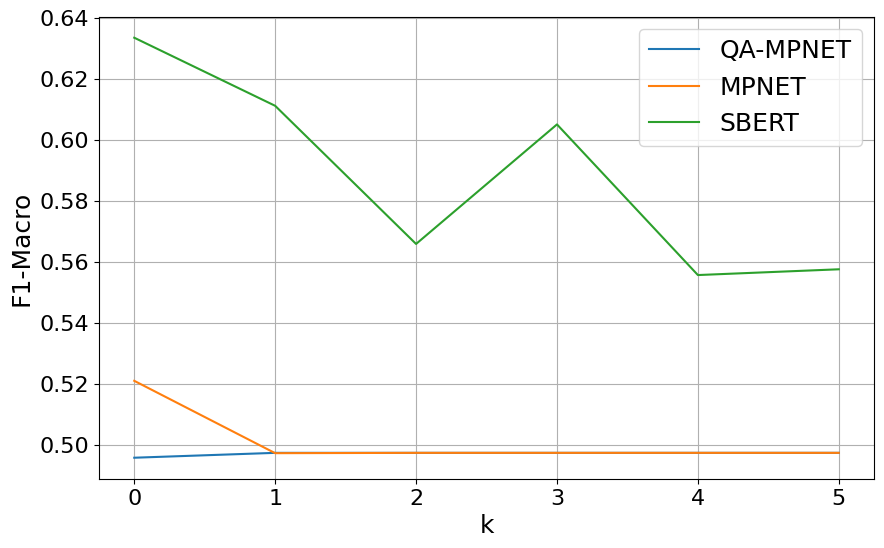

In [ ]:
avg_f1_knn_results.plot(
    xlabel = "k",
    ylabel = "F1-Macro",
    grid = True,
)
plt.show()

## k vs (-)es

In [ ]:
best_encoder = "bert-base-nli-mean-tokens"
db = pd.read_csv("DBs/db_full.csv")
retrieval_system = RetrievalSystem(db,best_encoder)

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
positive_db = retrieval_system.db_positive

In [ ]:
avg_negatives = {}
for k in range(1,21,1):
  negatives_per_cluster = []
  # Retrieve top-k according to L2
  for q in positive_db['Summary']:
    # Compute avg (+) distance from its cluste
    neighborhood =retrieval_system(q,top_k=k+1,upper_bound=None,lower_bound=None,metric='L2-NOT-SCALED',split=False)[1:]
    negatives_per_cluster.append(neighborhood[~neighborhood['Successful']].shape[0])
  avg_negatives[k] = sum(negatives_per_cluster) / positive_db.shape[0]

<Axes: xlabel='k', ylabel='#(-)es'>

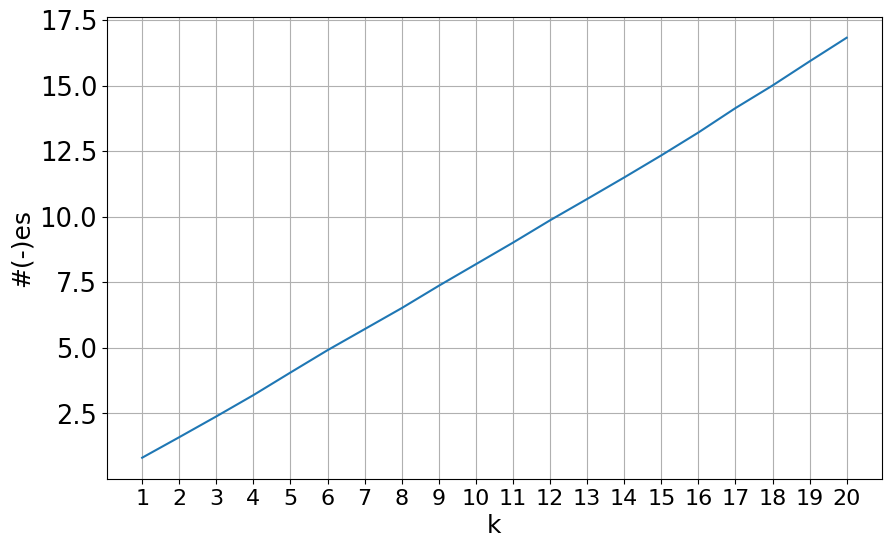

In [ ]:
pd.Series(avg_negatives).plot(
    xlabel = "k",
    ylabel = "#(-)es",
    grid = True,
    xticks = range(1,21,1),
)

In [ ]:
db_expl = pd.read_csv("DBs/db_expl.csv")

In [ ]:
retrieval_system_expl = RetrievalSystem(db_expl,best_encoder)

Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
positive_db = retrieval_system_expl.db_positive

In [ ]:
avg_negatives_expl = {}
for k in range(1,21,1):
  negatives_per_cluster = []
  # Retrieve top-k according to L2
  for q in positive_db['Summary']:
    # Compute avg (+) distance from its cluste
    neighborhood =retrieval_system_expl(q,top_k=k+1,upper_bound=None,lower_bound=None,metric='L2-NOT-SCALED',split=False)[1:]
    negatives_per_cluster.append(neighborhood[~neighborhood['Successful']].shape[0])
  avg_negatives_expl[k] = sum(negatives_per_cluster) / positive_db.shape[0]

<Axes: xlabel='k', ylabel='#(-)es'>

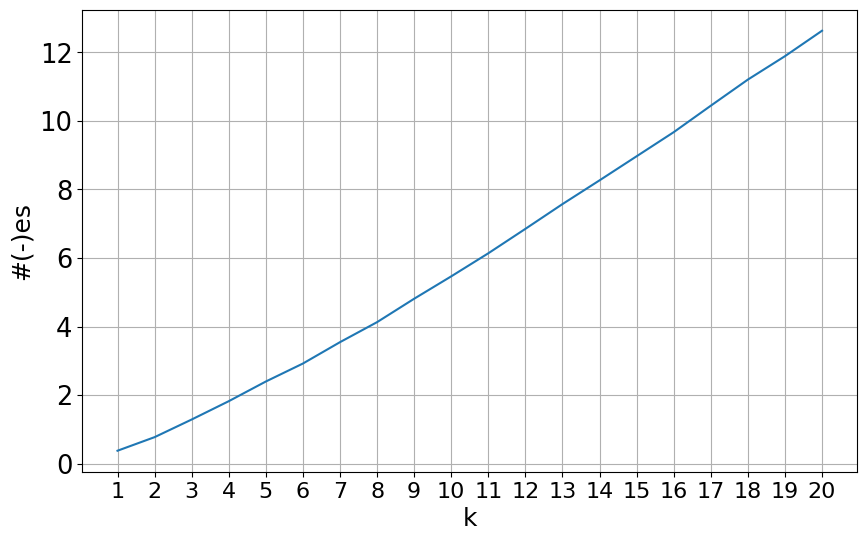

In [ ]:
pd.Series(avg_negatives_expl).plot(
    xlabel = "k",
    ylabel = "#(-)es",
    grid = True,
    xticks = range(1,21,1),
)

<Axes: xlabel='k', ylabel='Average #(-)es'>

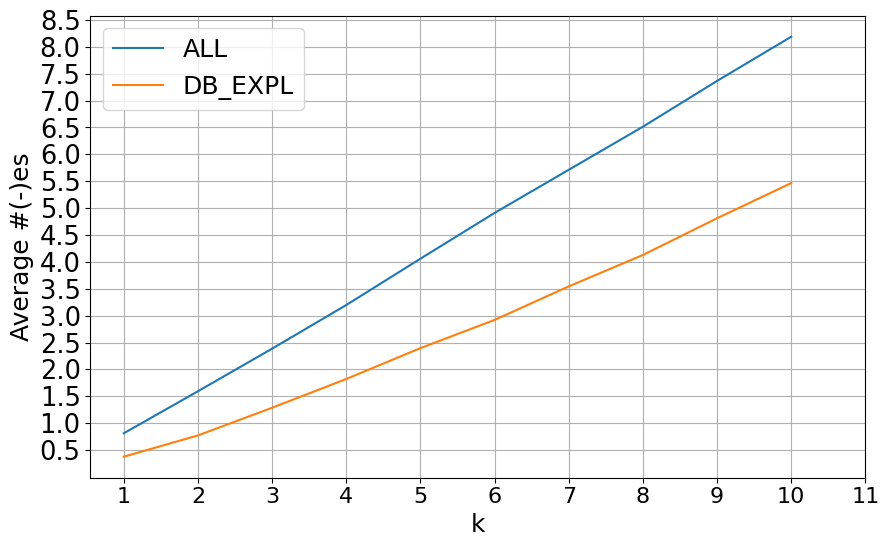

In [ ]:
pd.DataFrame([avg_negatives,avg_negatives_expl]).T.rename({0:'ALL', 1:'DB_EXPL'},axis = 1).loc[1:10].plot(
    xlabel = "k",
    ylabel = "Average #(-)es",
    grid = True,
    xticks = range(1,12,1),
    yticks = np.arange(0.5, 9, 0.5),
    legend = True,
)

## Embeddings Viz

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

def compute_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

def tsne_plot(reduced_embeddings, db, title):
    # Create new columns for the t-SNE coordinates
    db['x'] = reduced_embeddings[:, 0]
    db['y'] = reduced_embeddings[:, 1]

    # Create the plot
    plt.figure()

    # Plot positive points (successful = True) with stars, negative points with circles
    plt.scatter(db['x'][db['Successful'] == True], db['y'][db['Successful'] == True],
                c='#0088FF', s=50, alpha=1, marker='*', label='+')
    plt.scatter(db['x'][db['Successful'] == False], db['y'][db['Successful'] == False],
                c='#FF5600', s=5, alpha=0.5, marker='o', label='-')

    # Create the legend
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='#0088FF', markersize=15, label='+'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF5600', markersize=10, label='-')
    ]
    # Explicitly set the legend elements and their order
    plt.legend(handles=legend_elements, title="Label", loc='upper right')

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()


In [ ]:
sbert_tsne = compute_tsne(retrieval_systems['bert-base-nli-mean-tokens'].embeddings['not_scaled'])

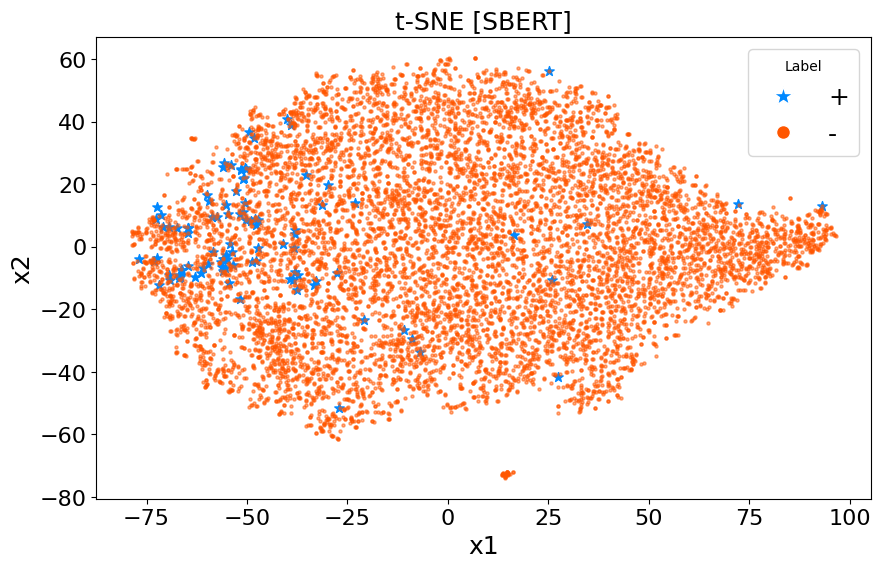

In [ ]:
tsne_plot(sbert_tsne, retrieval_systems['bert-base-nli-mean-tokens'].db, title = "t-SNE [SBERT]")

In [ ]:
mpnet_tsne = compute_tsne(retrieval_systems['all-mpnet-base-v2'].embeddings['not_scaled'])

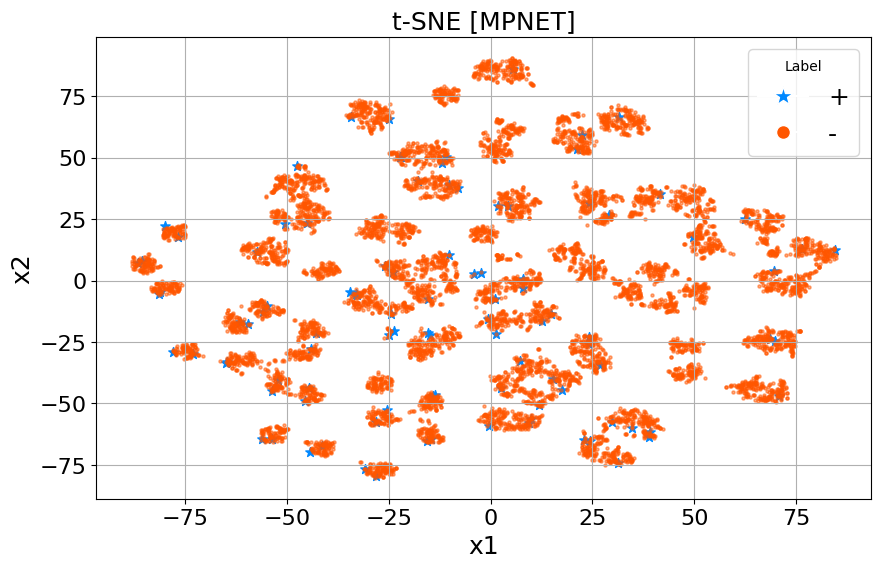

In [ ]:
tsne_plot(mpnet_tsne, retrieval_systems['all-mpnet-base-v2'].db, title = "t-SNE [MPNET]")

In [ ]:
def tsne_plot_by_feature(
    tsn: np.ndarray,  # TSNE embeddings
    db: pd.DataFrame,  # Database with additional information
    color_feature: str,  # Feature used for coloring
    marker_feature: str,  # Feature used for markers (e.g., 'Successful')
    title : str
):
    # Add TSNE coordinates to the DataFrame
    db['x'] = tsn[:, 0]
    db['y'] = tsn[:, 1]

    # Generate color map
    unique_colors = db[color_feature].unique()
    color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}

    # Initialize the plot
    plt.figure()

    # Create the scatter plot
    for marker_value in [True, False]:
        marker = '*' if marker_value else 'o'
        marker_size = 200 if marker_value else 8  # Increased size for stars
        alpha = 1 if marker_value else 0.7  # Set alpha to make stars more solid
        edgecolor = 'black' if marker_value else 'none'
        subset = db[db[marker_feature] == marker_value]
        plt.scatter(
            subset['x'],
            subset['y'],
            c=subset[color_feature].map(color_map),
            marker=marker,
            edgecolor=edgecolor,
            alpha=alpha,
            s=marker_size,
            label=None,  # Remove label here
            linewidth=0.9 if marker_value else 0  # Thicker border for stars
        )

    # Add titles and labels
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')

    # Add grid for visualization
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_legend_only(color_feature: str, db: pd.DataFrame):
    # Generate color map
    unique_colors = db[color_feature].unique()
    color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}

    # Create handles and labels for legend
    color_labels = list(unique_colors)
    color_handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markerfacecolor=color_map[label],
            markersize=10
        )
        for label in unique_colors
    ]

    # Create a blank figure for the legend
    plt.figure(figsize=(6, 2))  # Adjust size for better layout
    plt.legend(color_handles, color_labels, ncols = len(color_labels), title=color_feature, loc='center', ncol=2)
    plt.axis('off')  # Turn off the axes
    plt.tight_layout()
    plt.show()


### MPNET

<ipython-input-80-d28186d71f01>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-80-d28186d71f01>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}


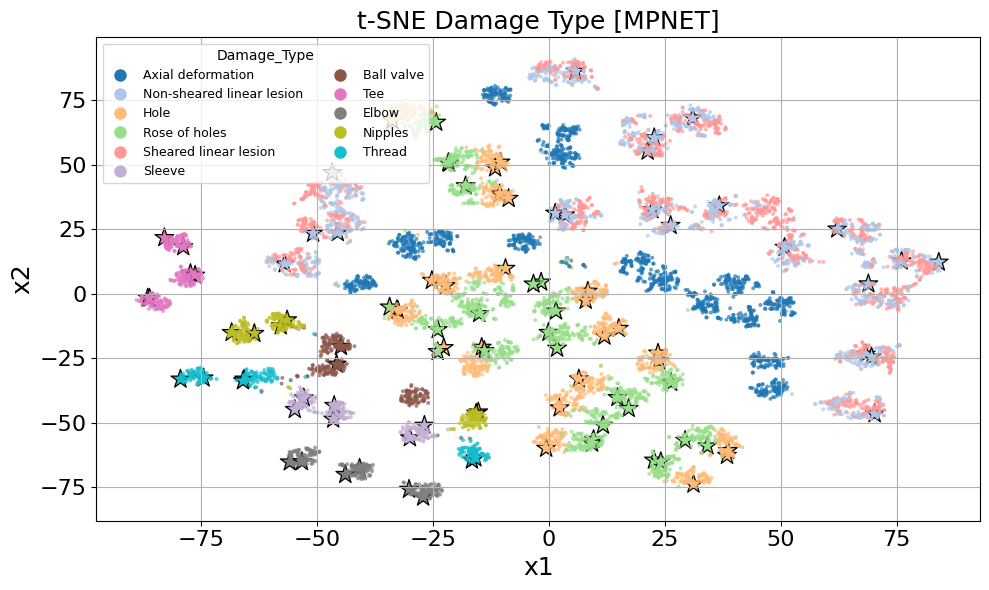

In [ ]:
tsne_plot_by_feature(mpnet_tsne,retrieval_systems['all-mpnet-base-v2'].db,color_feature = 'Damage_Type', marker_feature = 'Successful', title = "t-SNE Damage Type [MPNET]")

<ipython-input-82-b16c247f3793>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}


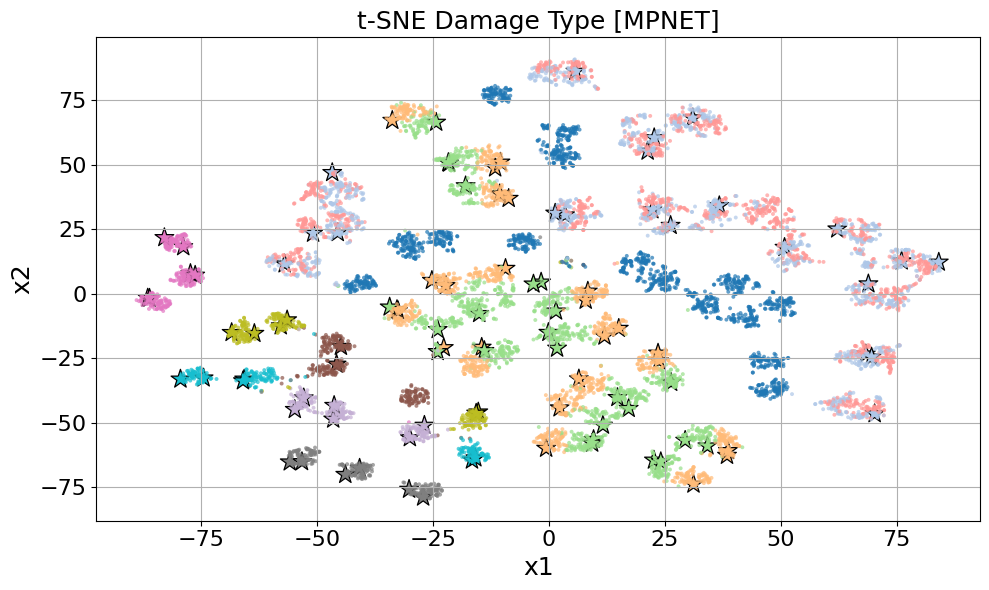

In [ ]:
tsne_plot_by_feature(mpnet_tsne,retrieval_systems['all-mpnet-base-v2'].db,color_feature = 'Damage_Type', marker_feature = 'Successful', title = "t-SNE Damage Type [MPNET]")

<ipython-input-92-4404ce4b12f7>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-92-4404ce4b12f7>:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


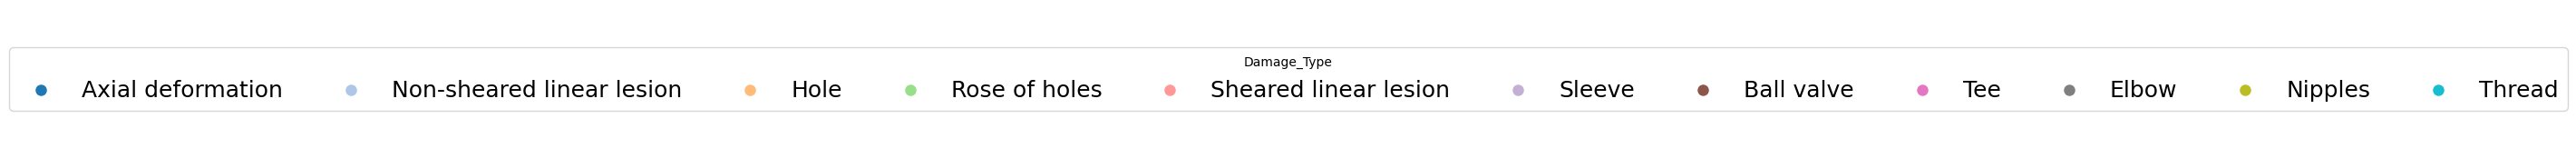

In [ ]:
plot_legend_only(color_feature = "Damage_Type",db = retrieval_systems['all-mpnet-base-v2'].db)

<ipython-input-37-795703801b2c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-37-795703801b2c>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}


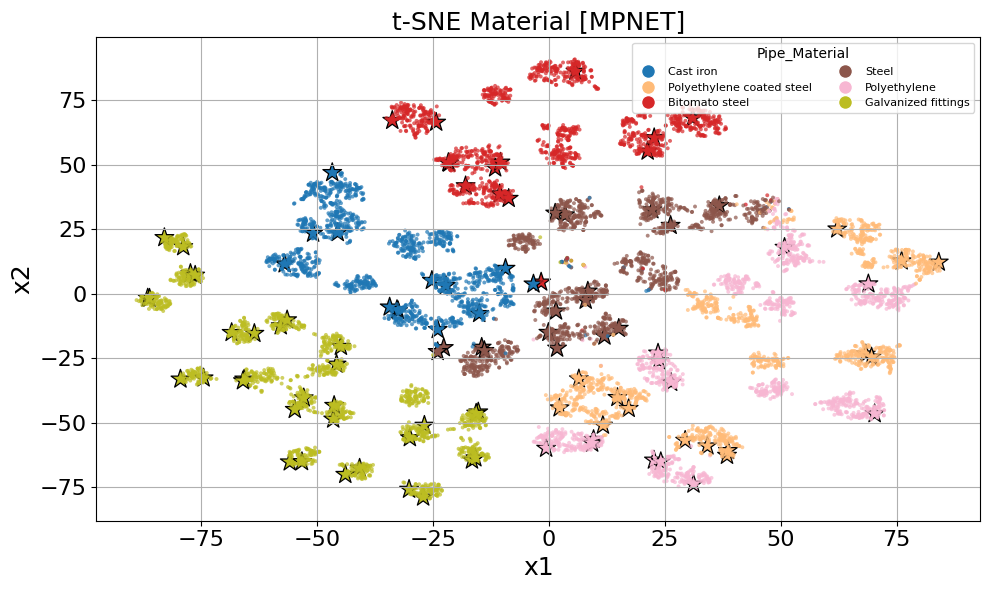

In [ ]:
tsne_plot_by_feature(mpnet_tsne,retrieval_systems['all-mpnet-base-v2'].db,color_feature = 'Pipe_Material', marker_feature = 'Successful',title = "t-SNE Material [MPNET]")

### SBERT-NLI

<ipython-input-93-d2768025a8e2>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}


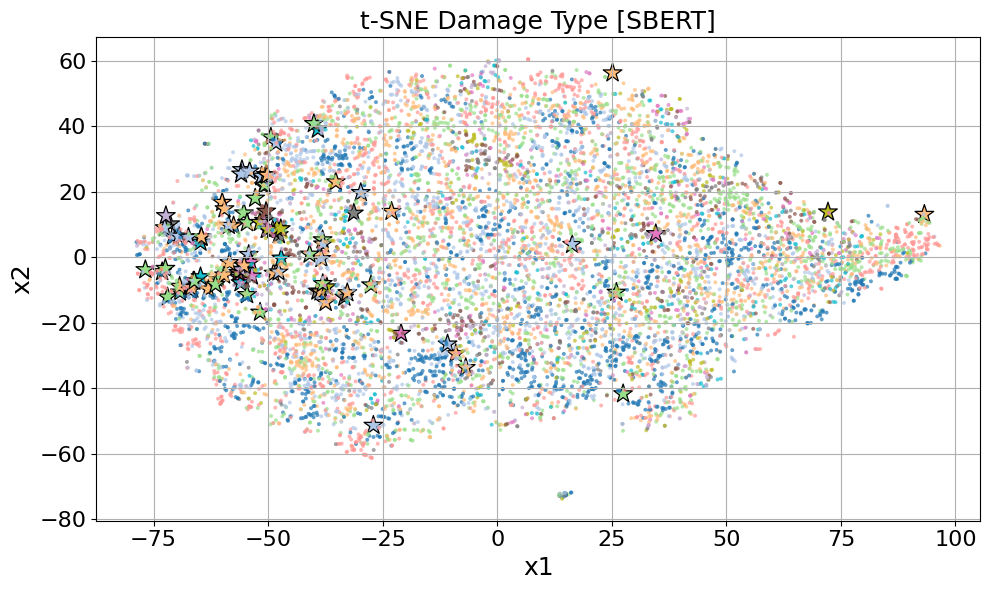

In [ ]:
tsne_plot_by_feature(sbert_tsne,retrieval_systems['bert-base-nli-mean-tokens'].db,color_feature = 'Damage_Type', marker_feature = 'Successful',title = "t-SNE Damage Type [SBERT]")

<ipython-input-37-795703801b2c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-37-795703801b2c>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}


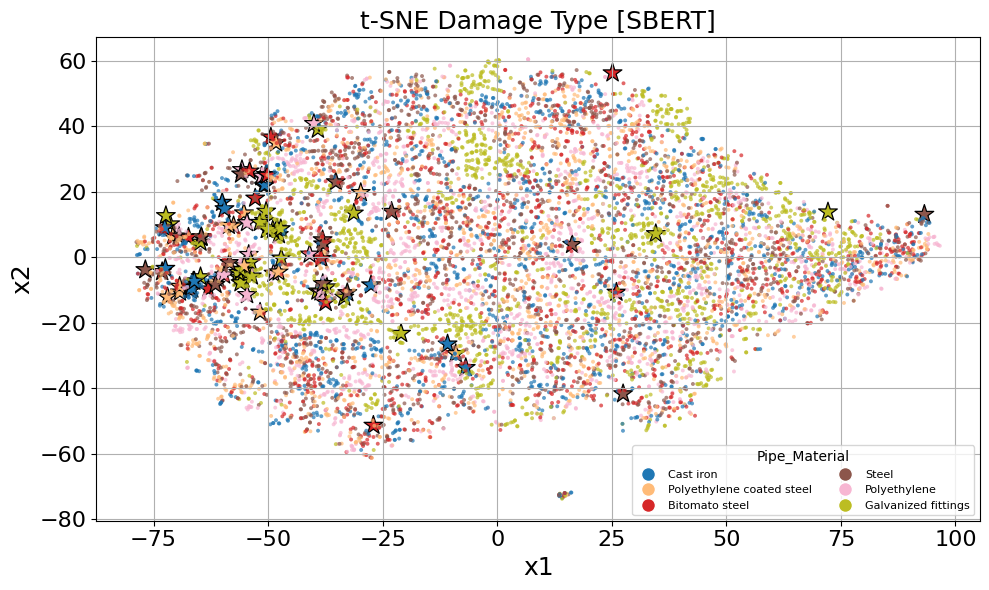

In [ ]:
tsne_plot_by_feature(sbert_tsne,retrieval_systems['bert-base-nli-mean-tokens'].db,color_feature = 'Pipe_Material', marker_feature = 'Successful',title = "t-SNE Damage Type [SBERT]")

### Double Plot

In [ ]:
# Simplifying presentation
db_full.loc[
    db_full['Damage_Type'] == 'Visible deformation in axial direction',
    'Damage_Type'
] = 'Axial deformation'

In [ ]:
def tsne_dual_plot(
    tsne1: np.ndarray, tsne2: np.ndarray,  # TSNE embeddings
    db: pd.DataFrame,  # Database with additional information
    color_feature: str,  # Feature used for coloring
    marker_feature: str,  # Feature used for markers (e.g., 'Successful')
    title_fig: str,  # Main title of the figure
    title1: str, title2: str,  # Titles for each subplot
    marker_label : dict = {True : 'Patchable', False : "NOT Patchable"}
):
    fig, axes = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'wspace': 0.05})  # Reduce space between subplots

    # Add TSNE coordinates to the DataFrame
    db['x1'], db['y1'] = tsne1[:, 0], tsne1[:, 1]
    db['x2'], db['y2'] = tsne2[:, 0], tsne2[:, 1]

    # Generate color map
    unique_colors = db[color_feature].unique()
    color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}

    # Plot both t-SNEs side by side
    for i, (ax, x_col, y_col, title) in enumerate(zip(axes, ['x1', 'x2'], ['y1', 'y2'], [title1, title2])):
        for marker_value in [True, False]:
            marker = '*' if marker_value else 'o'
            marker_size = 200 if marker_value else 8  # Larger stars for emphasis
            alpha = 1 if marker_value else 0.7  # Stars more solid
            edgecolor = 'black' if marker_value else 'none'
            linewidth = 0.9 if marker_value else 0
            subset = db[db[marker_feature] == marker_value]
            ax.scatter(
                subset[x_col], subset[y_col], c=subset[color_feature].map(color_map),
                marker=marker, edgecolor=edgecolor, alpha=alpha, s=marker_size, linewidth=linewidth
            )
        ax.set_title(title, fontsize=25)
        ax.grid(True)

        # Add custom legend for markers inside each subplot
        ax.scatter([], [], marker='*', s=100, color='black', label=marker_label[True])
        ax.scatter([], [], marker='o', s=50, color='black', label=marker_label[False])
        ax.legend(loc='upper right', fontsize=17, frameon=True)

    # Remove y-ticks and y-labels from second plot
    axes[1].tick_params(left=False, labelleft=False)

    # Common legend below both plots
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], markersize=8, label=str(val))
               for val in unique_colors]
    fig.legend(handles=handles, loc='lower center', ncol=len(unique_colors), bbox_to_anchor=(0.5, 0.02), fontsize=13.5)  # Reduce gap below plots

    # Global title
    fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit legend
    plt.show()


<ipython-input-120-c7ef316205cb>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-120-c7ef316205cb>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjust layout to fit legend


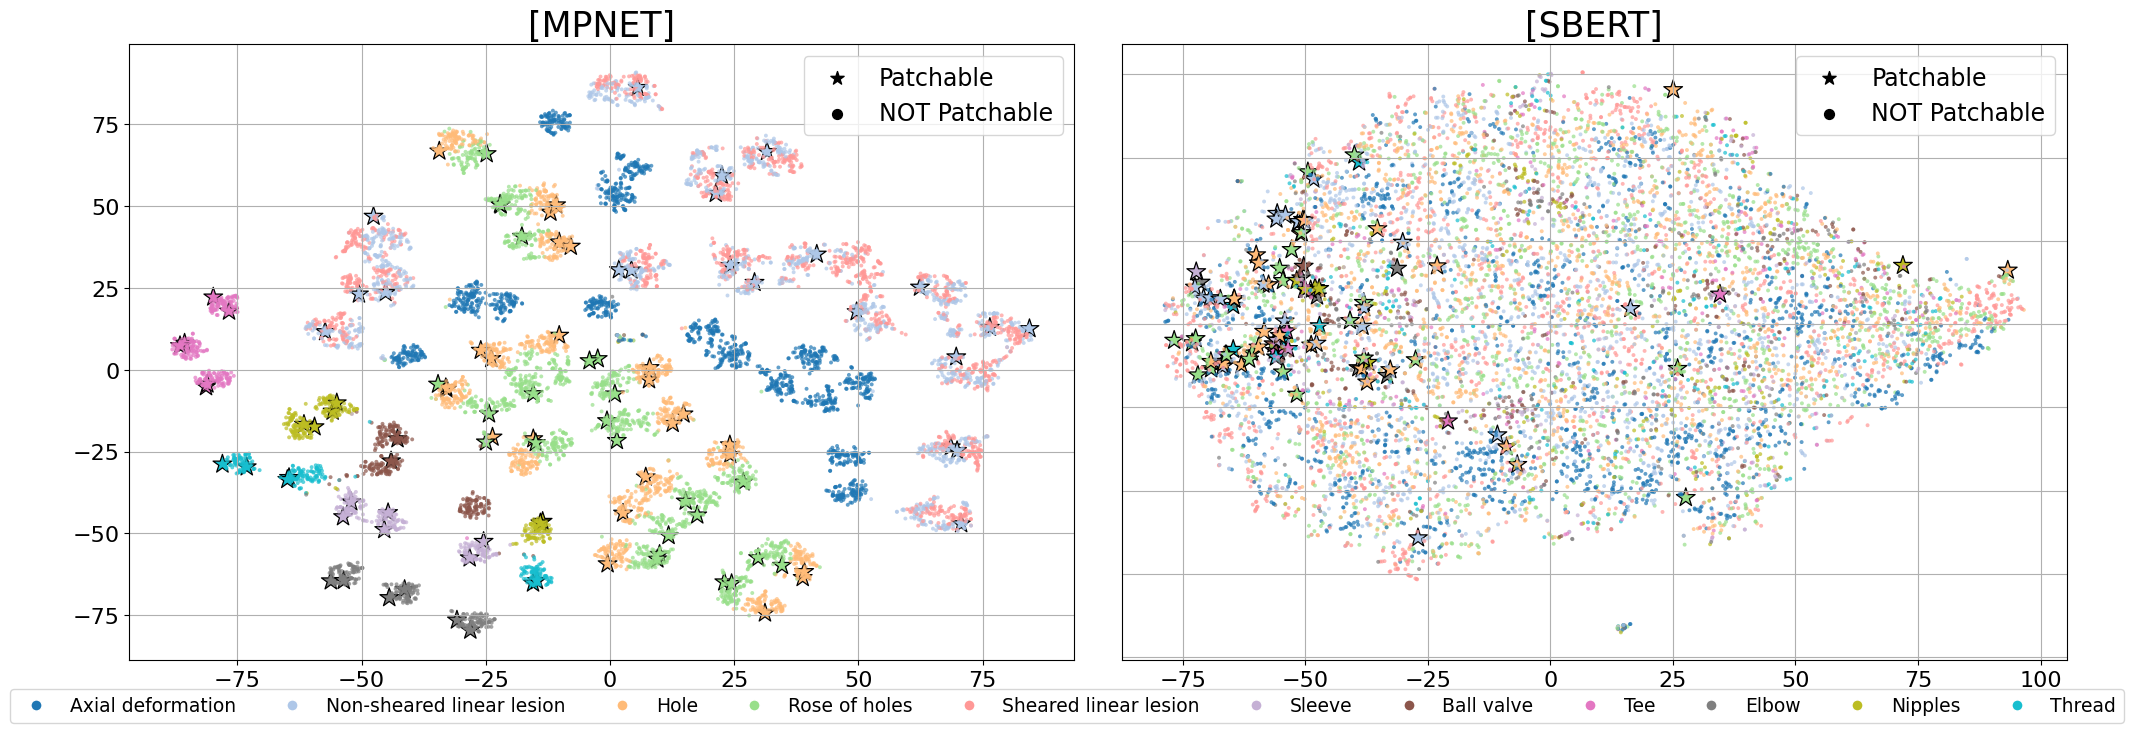

In [ ]:
tsne_dual_plot(
    mpnet_tsne, sbert_tsne,
    db_full
    color_feature = "Damage_Type",
    marker_feature = "Successful",
    title_fig = "t-SNE Sentence Embeddings",
    title1 = "[MPNET]", title2= "[SBERT]",
)

## Similarity Metrics

In [ ]:
best_rac = racs['bert-base-nli-mean-tokens']
metrics = ['IP','COS','L2-NOT-SCALED','L2-SCALED']

In [ ]:
# (-)es
_neg_df = query_full[~query_full['Successful']]
metric_selection_neg = pd.DataFrame({
    m: {f'Avg(F1)@{k}': _test_policy(best_rac, _neg_df, policy = "knn", top_k = k, metric=m)['Avg(F1)'] for k in k_range}
    for m in metrics
})

In [ ]:
# (+)es
_pos_df = query_full[query_full['Successful']]
metric_selection_pos = pd.DataFrame({
    m: {f'Avg(F1)@{k}': _test_policy(best_rac, _pos_df, policy = "knn", top_k = k, metric=m)['Avg(F1)'] for k in k_range}
    for m in metrics
})

In [ ]:
metric_selection_pos.to_csv('RESULTS/metric_selection_pos.csv')
metric_selection_neg.to_csv('RESULTS/metric_selection_neg.csv')

In [ ]:
metric_selection_pos

IP       COS  L2-NOT-SCALED  L2-SCALED
Avg(F1)@1   0.264706  0.193548       0.193548   0.193548
Avg(F1)@3   0.193548  0.137931       0.137931   0.137931
Avg(F1)@5   0.107143  0.038462       0.038462   0.038462
Avg(F1)@7   0.137931  0.038462       0.000000   0.038462
Avg(F1)@9   0.074074  0.038462       0.000000   0.038462
Avg(F1)@11  0.074074  0.000000       0.000000   0.000000

In [ ]:
metric_selection_neg

IP       COS  L2-NOT-SCALED  L2-SCALED
Avg(F1)@1   0.496689  0.498403       0.498510   0.498403
Avg(F1)@3   0.497762  0.499363       0.499256   0.499363
Avg(F1)@5   0.498403  0.499469       0.499469   0.499469
Avg(F1)@7   0.499150  0.499788       0.499788   0.499788
Avg(F1)@9   0.499256  0.499894       0.499894   0.499894
Avg(F1)@11  0.499363  0.500000       0.500000   0.500000

In [ ]:
import numpy as np

# Combine all embeddings into a single matrix
all_embeddings = np.vstack(best_rac.embeddings['not_scaled'])

# Compute variance for each dimension
variances = np.var(all_embeddings, axis=0)

# Find the index of the dimension with the maximal variance
max_variance_index = np.argmax(variances)
min_variance_index = np.argmin(variances)

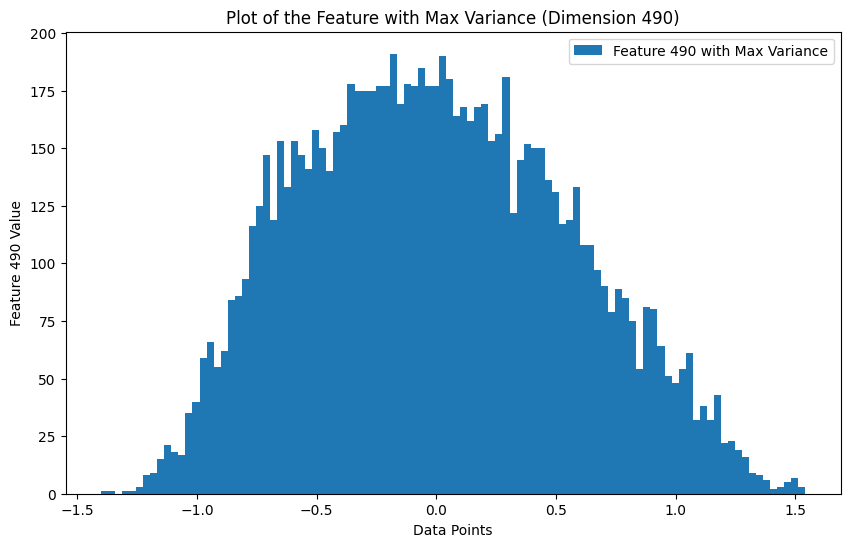

Feature 490 has the maximal variance: 0.3060910999774933


In [ ]:

# Plot the feature with the maximal variance
plt.figure(figsize=(10, 6))
plt.hist(all_embeddings[:, max_variance_index], label=f"Feature {max_variance_index} with Max Variance", bins=100)
plt.title(f"Plot of the Feature with Max Variance (Dimension {max_variance_index})")
plt.xlabel("Data Points")
plt.ylabel(f"Feature {max_variance_index} Value")
plt.legend()
plt.show()

print(f"Feature {max_variance_index} has the maximal variance: {variances[max_variance_index]}")

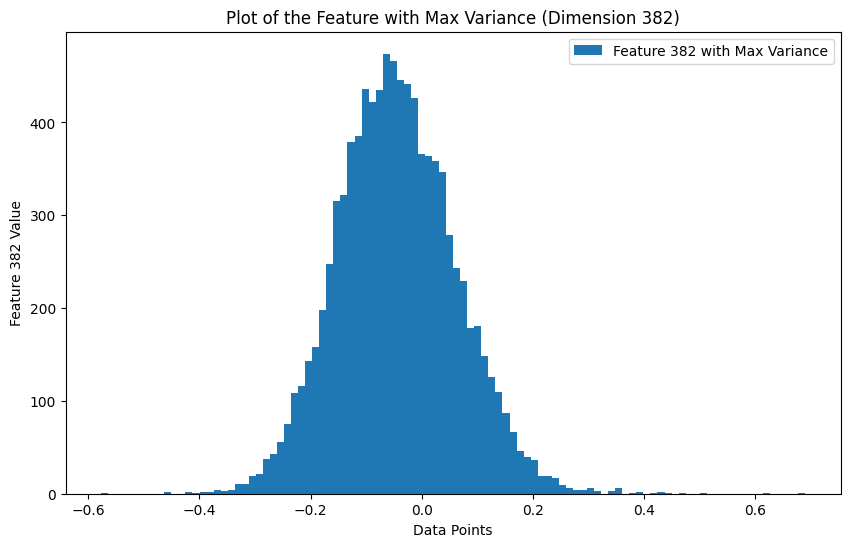

Feature 382 has the maximal variance: 0.01147075742483139


In [ ]:
# Plot the feature with the maximal variance
plt.figure(figsize=(10, 6))
plt.hist(all_embeddings[:, min_variance_index], label=f"Feature {min_variance_index} with Max Variance", bins=100)
plt.title(f"Plot of the Feature with Max Variance (Dimension {min_variance_index})")
plt.xlabel("Data Points")
plt.ylabel(f"Feature {min_variance_index} Value")
plt.legend()
plt.show()

print(f"Feature {min_variance_index} has the maximal variance: {variances[min_variance_index]}")

## Investigating MPNET vs BERT behaviour

In [ ]:
sbert_retriever = retrieval_systems['bert-base-nli-mean-tokens']
mpnet_retriever = retrieval_systems['all-mpnet-base-v2']

In [ ]:
positive_example= "An aerial pipe made of polyethlene having: a hole, no severe corrosion, no high pressure, no ribs"

In [ ]:
sbert_retriever.retrieve(positive_example,top_k = 3,split = False)

Unnamed: 0        ID  Kit_Size_num  Successful  Pipe_In_Bad_Conditions  \
2757        9709  ID009710             2       False                   False   
5352       11903  ID011904             3       False                   False   
3647        4719  ID004720             2       False                   False   

                  Pipe_Material                             Damage_Type  \
2757               Polyethylene                   Sheared linear lesion   
5352               Polyethylene  Visible deformation in axial direction   
3647  Polyethylene coated steel                           Rose of holes   

     Pipe_Exposure  Severe_Corrosion  Pipe_Covered  Branch_Near_Fault  \
2757   Aerial pipe             False          True              False   
5352   Underground             False         False              False   
3647   Aerial pipe             False          True              False   

      High_Pressure  Damaged_Valve   Ribs  \
2757          False           True  False   
5352          False          False  False   
3647          False          False  False   

                                                Summary  \
2757  Sheared linear lesion in an aerial polyethylen...   
5352  A visible deformation in the axial direction h...   
3647  Rose of holes on the polyethylene-coated steel...   

                                              Summary_1          IP  
2757  A linear lesion has developed in an aerial pol...  250.866821  
5352  Underground polyethylene pipes have visible de...  250.126785  
3647  The aerial pipe made of steel and coated with ...  249.671188

In [ ]:
mpnet_retriever.retrieve(positive_example,top_k = 3, split = False)

Unnamed: 0        ID  Kit_Size_num  Successful  Pipe_In_Bad_Conditions  \
4245        5424  ID005425             2       False                    True   
8428        4660  ID004661             2       False                    True   
876         3558  ID003559             2       False                   False   

                  Pipe_Material    Damage_Type Pipe_Exposure  \
4245               Polyethylene  Rose of holes   Aerial pipe   
8428  Polyethylene coated steel  Rose of holes   Aerial pipe   
876                Polyethylene           Hole   Aerial pipe   

      Severe_Corrosion  Pipe_Covered  Branch_Near_Fault  High_Pressure  \
4245             False         False               True           True   
8428             False         False               True          False   
876              False          True               True          False   

      Damaged_Valve  Ribs                                            Summary  \
4245           True  True  This aerial polyethylene pipe sustains numerou...   
8428           True  True  Rose of holes on a polyethylene-coated steel a...   
876           False  True  Aerial polyethylene pipes suffer from a hole i...   

                                              Summary_1        IP  
4245  This high-pressure, corrosion-resistant polyet...  0.829119  
8428  A polyethylene-coated steel aerial pipe with n...  0.809576  
876   Aerial polyethylene pipes sustain hole injurie...  0.805669

In [ ]:
device ='cuda:0'
sbert = {
    'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens'),
    'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
}
mpnet = {
    'tokenizer' : AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2'),
    'model' : AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
}
sbert['model'].to(device)
mpnet['model'].to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [ ]:
negative_example= "An underground pipe made of steel having: a rose of holes, severe corrosion, high pressure, damaged valve, ribs"

In [ ]:
# Initialize a dictionary to track occurrences of each token
from collections import defaultdict

def _name_tokens(encoded_input,tokenizer):
  token_counts = defaultdict(int)
  # Create tokens with suffixes only for duplicates
  tokens_with_suffix = []
  for word in tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]):
      if token_counts[word] > 0:  # If the word is already seen, add a suffix
          tokens_with_suffix.append(f"{word}_{token_counts[word]}")
      else:  # If it's the first occurrence, keep it as is
          tokens_with_suffix.append(word)
      token_counts[word] += 1  # Increment the count for the token
  return tokens_with_suffix

In [ ]:
from transformers import AutoTokenizer, AutoModel
def embeddings_dataframe(text : str,model,tokenizer):
  encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
  with torch.no_grad():
    model_output = model(**encoded_input)
  T = model_output[0].cpu().numpy().squeeze()
  # Create a list of tokens with unique identifiers
  tokens_with_index = _name_tokens(encoded_input,tokenizer)
  # Create the DataFrame, using the modified tokens as the index
  T_df = pd.DataFrame({token: embedding for token, embedding in zip(tokens_with_index, T)}).T
  v = T_df.mean(axis = 0).to_numpy()
  v_df = pd.DataFrame(
    [T_df.mean(axis=0).to_numpy()],
    columns=[f"x_{i}" for i in range(T_df.shape[1])]
    )
  v_onto_T = T @ v / np.linalg.norm(T,axis = 1)
  v_onto_T_df = pd.DataFrame(
    {"token": tokens_with_index, "v_onto_T": v_onto_T}).set_index("token")
  return T_df,v_df,v_onto_T_df

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(df1, df2):
    """
    Compute cosine similarity for matching tokens between two embedding DataFrames.

    Args:
        df1 (pd.DataFrame): First embedding DataFrame (tokens as index, embeddings as rows).
        df2 (pd.DataFrame): Second embedding DataFrame (tokens as index, embeddings as rows).

    Returns:
        pd.DataFrame: DataFrame with tokens as index and cosine similarity as a column.
    """
    # Ensure the indices match
    matching_indices = df1.index.intersection(df2.index)

    # Extract embeddings for matching tokens
    embeddings1 = df1.loc[matching_indices].to_numpy()
    embeddings2 = df2.loc[matching_indices].to_numpy()

    # Compute cosine similarity for matching tokens
    cos_similarities = cosine_similarity(embeddings1, embeddings2).diagonal()

    # Create and return a DataFrame with the results
    return pd.DataFrame({
        "token": matching_indices,
        "cosine_similarity": cos_similarities
    }).set_index("token")


In [ ]:
# SBERT
sbert_pos_T_df,sbert_pos_v,sbert_pos_v_onto_T = embeddings_dataframe(positive_example,sbert['model'],sbert['tokenizer'])
sbert_neg_T_df,sbert_neg_v,sbert_neg_v_onto_T = embeddings_dataframe(negative_example,sbert['model'],sbert['tokenizer'])

In [ ]:
sbert_neg_T_df

0         1         2         3         4         5    \
[CLS]        0.028358  0.336386  0.285484 -0.017356 -0.391855  0.094358   
an           0.472414  0.421856 -0.010896  0.112713 -0.038587 -0.096777   
underground  0.257158  0.547220 -0.455398  0.090413  0.375389 -0.400548   
pipe         0.938930  0.364774 -0.101425  0.135718 -0.174429 -0.211180   
made         0.667500  0.507590 -0.093932  0.119889 -0.094953 -0.237919   
of           0.470979  0.345794 -0.092542 -0.150662 -0.032321  0.042462   
steel        0.842146  0.430425 -0.137008 -0.105531  0.089217 -0.094036   
having       0.348651  0.195071  0.482271 -0.171739 -0.315249 -0.100562   
:            0.129677 -0.021117  0.236227 -0.095670 -0.252961  0.010669   
a            0.225131  0.274682  0.268788 -0.109447 -0.281522 -0.082702   
rose         0.423554  0.557868 -0.001901  0.018326 -0.086999 -0.188745   
of_1         0.300827  0.276969  0.363581 -0.198919 -0.335188  0.190413   
holes        0.691530  0.619791 -0.059891 -0.065498  0.176627 -0.032539   
,            0.326378  0.210883  0.622091 -0.023845 -0.388111 -0.157137   
severe       0.370018  0.239531  0.388988 -0.242305 -0.260737 -0.196825   
corrosion    0.607528  0.316798  0.222873 -0.113585 -0.256344 -0.027213   
,_1          0.343414  0.188525  0.633060 -0.054365 -0.350595 -0.240921   
high         0.186565  0.076151  0.269348 -0.289938 -0.136304 -0.399948   
pressure     0.674157  0.276169  0.026324 -0.172244 -0.050648 -0.362486   
,_2          0.281388  0.268970  0.621232 -0.094346 -0.324968 -0.170251   
damaged      0.249944  0.334211  0.012457 -0.022419  0.122162  0.008829   
valve        0.952560  0.459958  0.083601  0.098980 -0.087624 -0.253297   
,_3          0.362859  0.379143  0.584561 -0.065187 -0.275235 -0.026091   
ribs         0.543738  0.561959 -0.052244 -0.198826 -0.104717 -0.075585   
[SEP]        0.252962  0.360704  0.566659 -0.093824 -0.564891 -0.111815   

                  6         7         8         9    ...       758       759  \
[CLS]        0.729174  0.396688  0.260905 -1.027871  ...  1.362976  0.090086   
an           1.007100  0.314865  0.250633 -1.062011  ...  1.337813  0.107275   
underground  1.214989  0.360917  0.251739 -0.622775  ...  1.389885  0.401399   
pipe         0.822826  0.323265  0.738105 -0.927635  ...  1.403774  0.439857   
made         0.796631  0.536159  0.200549 -0.753408  ...  1.541402  0.146231   
of           0.640707  0.469967  0.189721 -0.831010  ...  1.259942 -0.043652   
steel        0.816174  0.234644 -0.072806 -0.811970  ...  1.091810  0.411980   
having       0.735606  0.605211  0.131018 -0.859794  ...  1.258762 -0.122937   
:            0.599924  0.447472  0.138252 -0.791861  ...  1.314992 -0.302984   
a            0.810782  0.547625  0.227637 -0.798412  ...  1.311737 -0.096513   
rose         0.599577  0.277857  0.237179 -0.655326  ...  1.060085 -0.224010   
of_1         0.585180  0.422691  0.256766 -0.940461  ...  1.260417 -0.185365   
holes        0.782201  0.402301  0.243799 -0.880255  ...  1.153173  0.185829   
,            0.635480  0.523912  0.352417 -0.919167  ...  1.067032  0.101812   
severe       0.525574  0.515728  0.234126 -0.722564  ...  1.076514  0.250319   
corrosion    0.775775  0.474394  0.074886 -0.685753  ...  1.098885  0.243396   
,_1          0.547947  0.451072  0.419306 -0.863398  ...  1.040405  0.081193   
high         0.171641  0.681079  0.176574 -0.620635  ...  0.952032 -0.122315   
pressure     0.588404  0.597530  0.224714 -0.881305  ...  1.340384  0.116190   
,_2          0.469112  0.481855  0.396369 -1.010964  ...  1.102146  0.037003   
damaged      0.325881  0.306341  0.192970 -0.589035  ...  1.011582  0.164619   
valve        0.996500  0.292579  0.611835 -1.011225  ...  1.221312  0.116066   
,_3          0.422694  0.412038  0.286539 -0.910857  ...  0.871920  0.096991   
ribs         0.299478  0.374335  0.194476 -0.669309  ...  1.223655 -0.044723   
[SEP]        0.678351  0.323037  0.364502 -0.719002  ...  1.161923 

In [ ]:
cosine_similarity(sbert_pos_v.to_numpy(),sbert_neg_v.to_numpy())[0][0]

0.273593

In [ ]:
cosine_similarity_sbert = compute_cosine_similarity(sbert_pos_T_df,sbert_neg_T_df)
cosine_similarity_sbert.T

token                 [CLS]        an      pipe      made        of    having  \
cosine_similarity  0.226406  0.265899  0.414253  0.326637  0.319528  0.232843   

token                     :         a         ,    severe  corrosion  \
cosine_similarity  0.251809  0.241561  0.235621  0.322156   0.412496   

token                   ,_1      high  pressure       ,_2   damaged     valve  \
cosine_similarity  0.227744  0.308243  0.399793  0.228419  0.364477  0.428973   

token                   ,_3      ribs     [SEP]  
cosine_similarity  0.222296  0.383505  0.255643

In [ ]:
# MPNET
mpnet_pos_T_df,mpnet_pos_v,mpnet_pos_v_onto_T = embeddings_dataframe(positive_example,mpnet['model'],mpnet['tokenizer'])
mpnet_neg_T_df,mpnet_neg_v,mpnet_neg_v_onto_T = embeddings_dataframe(negative_example,mpnet['model'],mpnet['tokenizer'])

In [ ]:
# MPNET cosine similarity
(mpnet_pos_T_df.loc['<s>'] @ mpnet_neg_T_df.loc['<s>'].T) / (np.linalg.norm(mpnet_pos_T_df.loc['<s>'])*np.linalg.norm(mpnet_neg_T_df.loc['<s>']) )

0.57116884

In [ ]:
cosine_similarity_mpnet = compute_cosine_similarity(mpnet_pos_T_df,mpnet_neg_T_df)
cosine_similarity_mpnet.T

token                   <s>        an      pipe      made        of    having  \
cosine_similarity  0.571169  0.710642  0.793994  0.766445  0.708988  0.639913   

token                     :         a         ,    severe  corrosion  \
cosine_similarity  0.669059  0.662017  0.674661  0.666864   0.798663   

token                   ,_1      high  pressure       ,_2   damaged     valve  \
cosine_similarity  0.689814  0.699936  0.751041  0.701336  0.750919  0.787133   

token                   ,_3      ribs      </s>  
cosine_similarity  0.710871  0.763075  0.595455

In [ ]:
sbert_pos_retrieved = sbert_retriever.retrieve(positive_example,top_k = 3,split = False).iloc[0]['Summary']
mpnet_pos_retrieved = mpnet_retriever.retrieve(positive_example,top_k = 3,split = False).iloc[0]['Summary']

In [ ]:
sbert_pos_retrieved_T_df,_,_ = embeddings_dataframe(sbert_pos_retrieved,sbert['model'],sbert['tokenizer'])
mpnet_pos_retrieved_T_df,_,_ = embeddings_dataframe(mpnet_pos_retrieved,mpnet['model'],mpnet['tokenizer'])

In [ ]:
cosine_similarity_sbert = compute_cosine_similarity(sbert_pos_T_df,sbert_pos_retrieved_T_df)
cosine_similarity_mpnet = compute_cosine_similarity(mpnet_pos_T_df,mpnet_pos_retrieved_T_df)

In [ ]:
cosine_similarity_sbert.T

token                 [CLS]        an  aerial      pipe      poly     ##eth  \
cosine_similarity  0.930755  0.913446  0.9238  0.936012  0.928741  0.908628   

token                     a         ,        no  corrosion       ,_1  \
cosine_similarity  0.855812  0.919434  0.948727   0.943176  0.900707   

token                  no_1     high  pressure      no_2     valve      ribs  \
cosine_similarity  0.943546  0.94492  0.945316  0.929631  0.911378  0.935355   

token                 [SEP]  
cosine_similarity  0.939975

In [ ]:
cosine_similarity_mpnet.T

token                   <s>    aerial      pipe        of      poly     ##eth  \
cosine_similarity  0.729865  0.885123  0.869347  0.641833  0.833353  0.776324   

token                     a         ,       no  corrosion       ,_1      high  \
cosine_similarity  0.723763  0.762709  0.74628   0.859482  0.835473  0.632647   

token              pressure       ,_2      ribs      </s>  
cosine_similarity  0.771694  0.765095  0.730031  0.697937

In [ ]:
rephrase_positive_example = "A polyethylene aerial pipe featuring a single hole, no significant corrosion, low pressure, an intact valve, and no ribs."
rephrased_negative_example = "A steel underground pipe with multiple holes, severe corrosion, high pressure, a damaged valve, and prominent ribs."

In [ ]:
sbert_retriever.retrieve(rephrase_positive_example,top_k = 3,split = False)

Unnamed: 0        ID  Kit_Size_num  Successful  Pipe_In_Bad_Conditions  \
2757        9709  ID009710             2       False                   False   
7197         869  ID000870             4       False                   False   
3647        4719  ID004720             2       False                   False   

                  Pipe_Material                Damage_Type Pipe_Exposure  \
2757               Polyethylene      Sheared linear lesion   Aerial pipe   
7197  Polyethylene coated steel  Non-sheared linear lesion   Aerial pipe   
3647  Polyethylene coated steel              Rose of holes   Aerial pipe   

      Severe_Corrosion  Pipe_Covered  Branch_Near_Fault  High_Pressure  \
2757             False          True              False          False   
7197             False          True               True          False   
3647             False          True              False          False   

      Damaged_Valve   Ribs                                            Summary  \
2757           True  False  Sheared linear lesion in an aerial polyethylen...   
7197           True  False  The aerial polyethylene-coated steel pipe sust...   
3647          False  False  Rose of holes on the polyethylene-coated steel...   

                                              Summary_1          IP  
2757  A linear lesion has developed in an aerial pol...  256.375702  
7197  The polyethylene-coated steel pipe with a bran...  251.566574  
3647  The aerial pipe made of steel and coated with ...  251.041138

In [ ]:
mpnet_retriever.retrieve(rephrase_positive_example,top_k = 3,split = False)

Unnamed: 0        ID  Kit_Size_num  Successful  Pipe_In_Bad_Conditions  \
719         2796  ID002797             2       False                   False   
4245        5424  ID005425             2       False                    True   
8428        4660  ID004661             2       False                    True   

                  Pipe_Material    Damage_Type Pipe_Exposure  \
719   Polyethylene coated steel           Hole   Aerial pipe   
4245               Polyethylene  Rose of holes   Aerial pipe   
8428  Polyethylene coated steel  Rose of holes   Aerial pipe   

      Severe_Corrosion  Pipe_Covered  Branch_Near_Fault  High_Pressure  \
719              False          True              False          False   
4245             False         False               True           True   
8428             False         False               True          False   

      Damaged_Valve  Ribs                                            Summary  \
719            True  True  Aerial polyethylene coated steel pipe with a h...   
4245           True  True  This aerial polyethylene pipe sustains numerou...   
8428           True  True  Rose of holes on a polyethylene-coated steel a...   

                                              Summary_1        IP  
719   Aerial polyethylene coated steel pipe with a h...  0.801885  
4245  This high-pressure, corrosion-resistant polyet...  0.797503  
8428  A polyethylene-coated steel aerial pipe with n...  0.794612

### Bert vs MPNET

In [ ]:
example_1= "An aerial pipe made of polyethlene having: a hole, corrosion, low pressure, no ribs"
example_2= "An aerial pipe made of polyethlene having: a hole, no corrosion, high pressure, no ribs"

In [ ]:
sbert_ex1_T_df,v1,_ = embeddings_dataframe(example_1,sbert['model'],sbert['tokenizer'])
sbert_ex2_T_df,v2,_ = embeddings_dataframe(example_2,sbert['model'],sbert['tokenizer'])

In [ ]:
mpnet_ex1_T_df,_,_ = embeddings_dataframe(example_1,mpnet['model'],mpnet['tokenizer'])
mpnet_ex2_T_df,_,_ = embeddings_dataframe(example_2,mpnet['model'],mpnet['tokenizer'])

In [ ]:
# SBERT cosine similarity
cosine_similarity(v1.to_numpy(),v2.to_numpy())[0][0]

0.8900805

In [ ]:
# MPNET cosine similarity
(mpnet_ex1_T_df.loc['<s>'] @ mpnet_ex2_T_df.loc['<s>'].T) / (np.linalg.norm(mpnet_ex1_T_df.loc['<s>'])*np.linalg.norm(mpnet_ex2_T_df.loc['<s>']) )

0.9890966

In [ ]:
example_1= "An aerial pipe made of steel having: a hole, no corrosion, low pressure, no ribs"
example_2= "An aerial pipe made of polyethlene having: a hole, no corrosion, low pressure, no ribs"

In [ ]:
sbert_ex1_T_df,v1,_ = embeddings_dataframe(example_1,sbert['model'],sbert['tokenizer'])
sbert_ex2_T_df,v2,_ = embeddings_dataframe(example_2,sbert['model'],sbert['tokenizer'])

In [ ]:
mpnet_ex1_T_df,_,_ = embeddings_dataframe(example_1,mpnet['model'],mpnet['tokenizer'])
mpnet_ex2_T_df,_,_ = embeddings_dataframe(example_2,mpnet['model'],mpnet['tokenizer'])

In [ ]:
# SBERT
cosine_similarity(v1.to_numpy(),v2.to_numpy())[0][0]

0.93286896

In [ ]:
# MPNET cosine similarity
(mpnet_ex1_T_df.loc['<s>'] @ mpnet_ex2_T_df.loc['<s>'].T) / (np.linalg.norm(mpnet_ex1_T_df.loc['<s>'])*np.linalg.norm(mpnet_ex2_T_df.loc['<s>']) )

0.814152

## Token frequency

In [ ]:
from transformers import AutoTokenizer
_t = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

In [ ]:
_t.__class__

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [ ]:
from sklearn.model_selection import train_test_split
_,test_df = train_test_split(db_full, test_size=0.20, stratify=db_full['Successful'], random_state=42)

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# Load models and tokenizers
bert_mean = {
    'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens'),
    'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
}
bert_mean['model'].to('cuda:0')

# bert_cls = {
#     'tokenizer': AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-cls-token'),
#     'model': AutoModel.from_pretrained('sentence-transformers/bert-base-nli-cls-token')
# }
# bert_cls['model'].to('cuda:0')

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download the list of stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Set of punctuation marks
punctuation_set = set(string.punctuation)

# Initialize tokenizer and model
tokenizer = bert_mean['tokenizer']

# Function to process text in batches
def get_most_frequent_tokens(texts, batch_size=32):
    token_counter = Counter()
    token_without_stopwords_counter = Counter()

    # Process the texts in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        # Tokenize the current batch of texts
        batch_texts = texts[i:i + batch_size]
        # Tokenize the texts (this converts them to token ids)
        encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt')

        # Extract tokens for each text in the batch
        for encoding in encodings['input_ids']:
            tokens = encoding.tolist()
            # Remove padding tokens (token id 0) and update counter
            tokens = [token for token in tokens if token != tokenizer.pad_token_id]
            decoded_tokens = [tokenizer.decode([token_id]).strip() for token_id in tokens]
            token_counter.update(decoded_tokens)

            # Now, remove stopwords and punctuation, and update the counter for tokens without stopwords
            decoded_tokens = [tokenizer.decode([token_id]).strip() for token_id in tokens]
            filtered_tokens = [token for token in decoded_tokens if token.lower() not in stop_words and token not in punctuation_set]
            token_without_stopwords_counter.update(filtered_tokens)

    # Order tokens
    most_common_tokens_without_stopwords = token_without_stopwords_counter.most_common()
    most_common_tokens = token_counter.most_common()

    # Return dictionary with the most frequent tokens excluding stopwords and punctuation
    return dict(most_common_tokens), dict(most_common_tokens_without_stopwords)

texts = data['Summary'].tolist()  # Convert to list if it's a Pandas DataFrame

# Get the dictionary with the most frequent tokens excluding stopwords and punctuation
result = get_most_frequent_tokens(texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 372/372 [01:03<00:00,  5.87it/s]


In [ ]:
with open('RESULTS\most_frequent_tokens.json', 'w') as json_file:
    json.dump(result, json_file)

In [ ]:
with open('RESULTS\most_frequent_tokens.json', 'r') as json_file:
    result = json.load(json_file)

# Now 'result' contains the data from the file
print(result)

[{'the': 82756, '.': 45547, ',': 40537, 'a': 38244, 'pipe': 34564, 'is': 32190, 'of': 23346, 'and': 23033, 'to': 20221, 'break': 16550, 'near': 16287, 'there': 16151, 'no': 15132, 'corrosion': 14361, 'in': 13271, 'pressure': 13197, 'by': 12928, 'strong': 12730, 'high': 12460, '[CLS]': 11904, '[SEP]': 11904, 'ribs': 11257, 'wall': 10626, 'covered': 9710, 'has': 9684, 'conditions': 9483, 'not': 9373, 'presence': 9296, 'are': 8891, 'branch': 8662, 'that': 8494, 'valve': 8448, 'bad': 8442, 'due': 7716, 'fault': 7454, 'or': 6825, 'this': 6753, 'steel': 6072, 'present': 5777, '-': 5402, 'within': 4790, 'have': 4697, 'injury': 4500, 'on': 4357, 'aerial': 4258, 'shear': 4246, '##ion': 4226, 'les': 4212, 'may': 4194, '##ed': 4107, 'linear': 4084, 'underground': 4083, 'poly': 4019, '##eth': 4019, '##yle': 4019, '##ne': 4019, 'user': 3954, 'material': 3937, 'connections': 3890, 'however': 3777, 'but': 3760, 'at': 3666, 'damage': 3447, 'additionally': 3396, 'located': 3147, 'it': 3097, 'despite': 

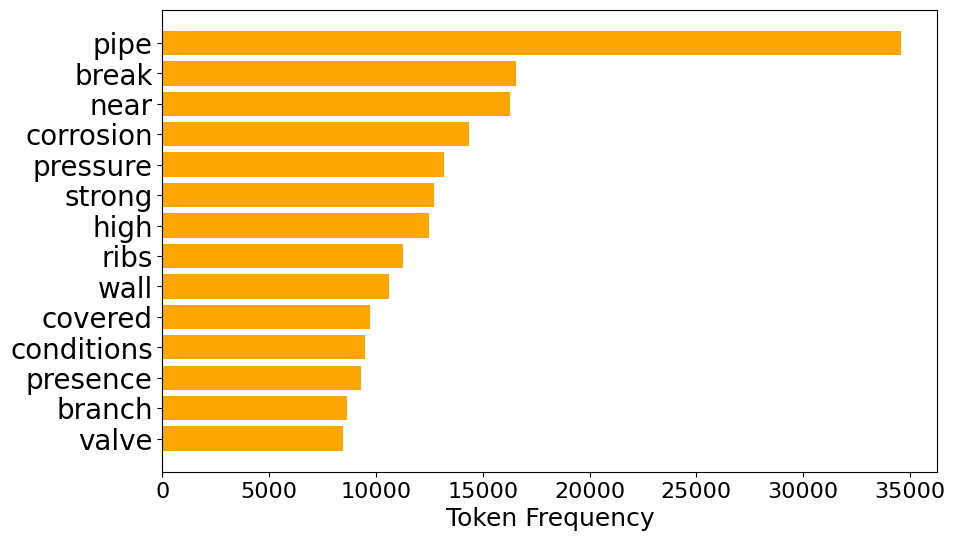

In [ ]:
import matplotlib.pyplot as plt

# Set the number of top-k words to display
k = 14  # You can adjust this value to display the top-k words

# Get the top-k most frequent words (excluding stopwords and punctuation)
top_k_words = dict(list(result[1].items())[:k + 2])

# Remove special tokens
top_k_words = {key: value for key, value in top_k_words.items() if key not in ['[CLS]', '[SEP]']}

# Plotting the bar chart for the top-k words
plt.figure()

plt.barh(list(top_k_words.keys()), list(top_k_words.values()), color='orange')
plt.xlabel('Token Frequency')
plt.gca().invert_yaxis()  # To show the most frequent word on top

# Adjust y-tick spacing
plt.yticks(ticks=range(len(top_k_words)), labels=list(top_k_words.keys()), fontsize=20)

plt.savefig("top_k_words.pdf", format="pdf", bbox_inches="tight")

plt.show()


## Sparse Vector Representation.

In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
# Parametri configurabili
k_values = list(range(1, 12, 2))  # K variabile: 1, 3, 5, ..., 11

# Split delle feature e dei target
db_texts = db_full['Summary']
db_labels = db_full['Successful']
query_texts = query_full['Summary']
query_labels = query_full['Successful']

# Funzione per valutare BoW e TF-IDF
def evaluate_retrieval_system(vectorizer, db_texts, db_labels, query_texts, query_labels, k_values):
    # Vectorizzazione
    X_db = vectorizer.fit_transform(db_texts)
    X_query = vectorizer.transform(query_texts)

    results = []

    # K-Nearest-Neighbor per diversi valori di K
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        knn.fit(X_db, db_labels)

        # Predizioni
        predictions = knn.predict(X_query)
        macro_f1 = f1_score(query_labels, predictions, average='macro')

        # Salva i risultati
        results.append({
            'K': k,
            'Vectorization': vectorizer.__class__.__name__,
            'Macro_F1': macro_f1
        })

    return results

# Valutazione per BoW e TF-IDF
vectorizers = [CountVectorizer(binary=True), TfidfVectorizer()]
all_results = []

for vectorizer in vectorizers:
    results = evaluate_retrieval_system(vectorizer, db_texts, db_labels, query_texts, query_labels, k_values)
    all_results.extend(results)

# Risultati finali in DataFrame
results_df = pd.DataFrame(all_results)
results_pivot = results_df.pivot(index='K', columns='Vectorization', values='Macro_F1')

In [ ]:
# Mostra i risultati
print("Risultati delle performance BoW e TF-IDF (Macro F1):")
_mapper = {"CountVectorizer" : 'BoW', "TfidfVectorizer" : "TF-IDF"}
results_pivot = results_pivot.rename(_mapper, axis = 1)

Risultati delle performance BoW e TF-IDF (Macro F1):


<Axes: title={'center': 'KNN for Sparse Vector Representation'}, xlabel='K'>

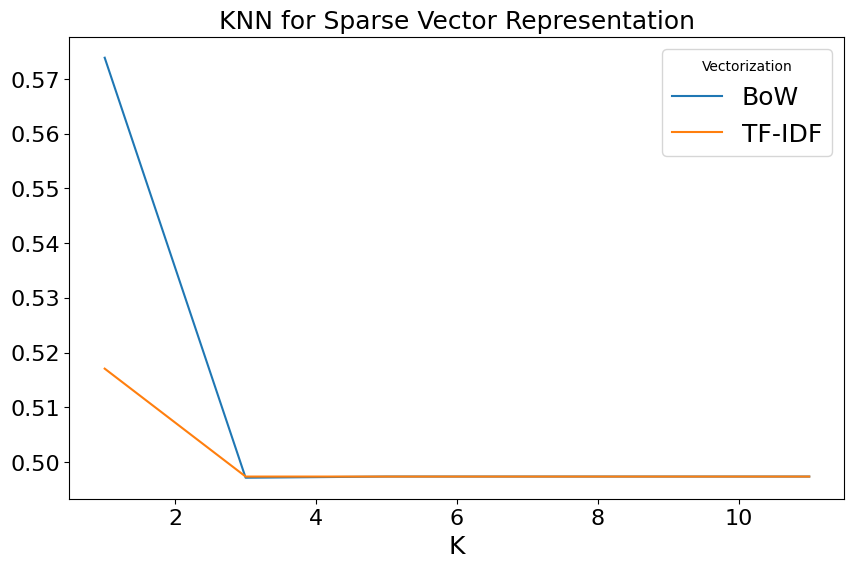

In [ ]:
fig,ax = plt.subplots()
ax.set_title('KNN for Sparse Vector Representation')
results_pivot.plot(
    ax = ax
)

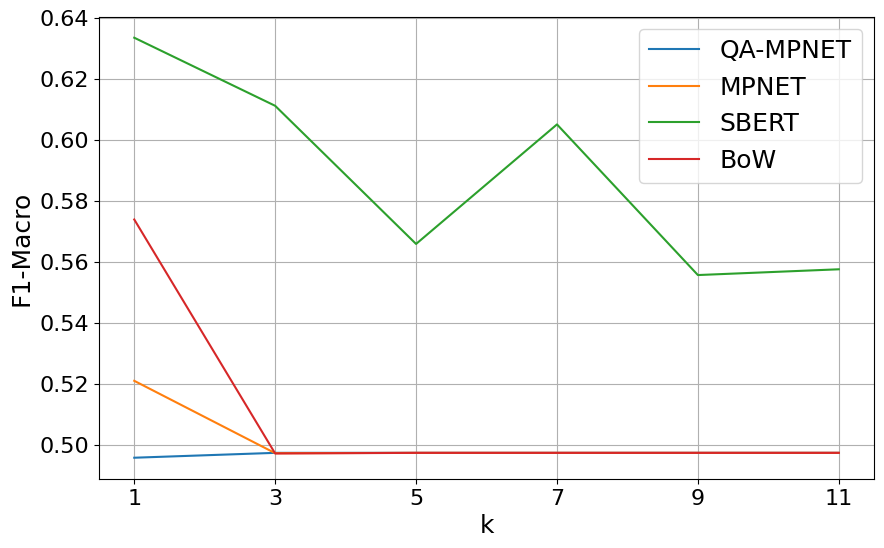

In [ ]:
import matplotlib.pyplot as plt

r = avg_f1_knn_results.join(results_pivot.reset_index()).set_index('K').drop('TF-IDF', axis=1)

# Plotting
ax = r.plot(
    xlabel="k",
    ylabel="F1-Macro",
    grid=True,
)

# Set the x-ticks to correspond to the values of 'K'
ax.set_xticks(r.index)

# Display the plot
plt.show()


In [ ]:
r.reset_index = range(1, len(r)*2, 2)

In [ ]:
r

QA-MPNET     MPNET     SBERT   K       BoW    TF-IDF
0  0.495765  0.520976  0.633458   1  0.573868  0.517074
1  0.497361  0.497255  0.611138   3  0.497149  0.497361
2  0.497361  0.497361  0.565847   5  0.497361  0.497361
3  0.497361  0.497361  0.605039   7  0.497361  0.497361
4  0.497361  0.497361  0.555651   9  0.497361  0.497361
5  0.497361  0.497361  0.557540  11  0.497361  0.497361

# Decoder Selection
We select the most promising model for gas pipe repairs classification by asking him to label queries without seeing any example (intrinsic knowledge)

In [ ]:
models_names = ['llama3.2','llama2:13b','mistral']

In [ ]:
template= """
You are a pipeline maintenance assistant with expertise in gas pipe repairs.
Your task is to determine if a pipe leak can be repaired by patches.

Answer selecting one of the following options:
- "YES" if the damage can be repaired by patches;
- "NO" if the damage cannot be repaired by patches.
** do not write any word but either YES or NO**

### Damage Description:
{description}

### Answer:"""

In [ ]:
# Helper function to simplify generation
from warnings import warn
def generate(description,chain):
  resp = chain.invoke({'description':description})
  return resp

# Helper function to normalize the answer
def normalize(resp):
  _r = resp.strip().strip("\n").strip('.').upper()
  if _r == "YES":
    return True
  if _r == "NO":
    return False
  else:
    warn(f"The answer {resp} does not match neither YES nor NO.")
    return resp

In [ ]:
from langchain_ollama.llms import OllamaLLM
from langchain.prompts import ChatPromptTemplate

# Create prompt for chatting
prompt = ChatPromptTemplate.from_template(template)

# Create a chain for each mode
chains = {model_name : prompt | OllamaLLM(model=model_name) for model_name in models_names}

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def run_zero_shot(model_name, queries, chains, generate, normalize, downsample=None, n_runs=5):
    metrics = {}

    # Generate answers using the model for the first run
    raw_answers = queries['Summary'].apply(generate, chain=chains[model_name])
    answers = raw_answers.apply(normalize)

    # Detect non-compliant answers
    _to_evaluate = [id for id, a in answers.items() if isinstance(a, bool)]
    y_true = queries['Successful'].loc[_to_evaluate].astype(bool)
    y_pred = answers.loc[_to_evaluate].astype(bool)

    # Calculate main metrics
    p, r, f, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average=None)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Print metrics
    print("--------------------------------------------------------")
    print(f"Metrics for model {model_name}:")
    print(f"Avg(F1): {sum(f) / 2:.3f}")
    print(f"Avg(P): {sum(p) / 2:.3f}")
    print(f"Avg(R): {sum(r) / 2:.3f}")
    print(f"P(+): {p[1]:.3f}, R(+): {r[1]:.3f}, F1(+): {f[1]:.3f}")
    print(f"P(-): {p[0]:.3f}, R(-): {r[0]:.3f}, F1(-): {f[0]:.3f}")
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print("--------------------------------------------------------")

    # Calculate Self Consistency
    # Downsample the data for self-consistency
    query_for_self_consistency= queries

    # Run the model n_runs times on the same subset and collect predictions
    all_answers = []

    for _ in range(n_runs):
        raw_answers_run = query_for_self_consistency['Summary'].apply(generate, chain=chains[model_name])
        answers_run = raw_answers_run.apply(normalize)
        all_answers.append(answers_run)

    # Convert list of predictions into a DataFrame
    all_answers_df = pd.DataFrame(all_answers).T

    # Check for consistency across the n runs
    stable_predictions = (all_answers_df.nunique(axis=1) == 1).sum()
    consistency = stable_predictions / len(all_answers_df)

    print(f"Self Consistency: {consistency:.3f}")

    # Record metrics in dictionary
    metrics = {
        'Avg(F1)': sum(f) / 2,
        'Self Consistency': consistency,  # This is the normalized self-consistency value
    }

    # Save results to CSV
    results_df = pd.DataFrame([metrics])
    results_df.to_csv(f"RESULTS/{model_name}_zero_shot.csv", index=False)

    return metrics

In [ ]:
# Downsampled query run
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")
zero_shot_results_downsampled = { model_name : run_zero_shot(model_name, query_downsampled, chains, generate, normalize) for model_name in models_names}

--------------------------------------------------------
Metrics for model llama3.2:
Avg(F1): 0.620
Avg(P): 0.627
Avg(R): 0.615
P(+): 0.409, R(+): 0.360, F1(+): 0.383
P(-): 0.845, R(-): 0.870, F1(-): 0.857
TP: 9, FP: 13, TN: 87, FN: 16
--------------------------------------------------------
Self Consistency: 0.752


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------------------------
Metrics for model llama2:13b:
Avg(F1): 0.444
Avg(P): 0.400
Avg(R): 0.500
P(+): 0.000, R(+): 0.000, F1(+): 0.000
P(-): 0.800, R(-): 1.000, F1(-): 0.889
TP: 0, FP: 0, TN: 100, FN: 25
--------------------------------------------------------
Self Consistency: 1.000
--------------------------------------------------------
Metrics for model mistral:
Avg(F1): 0.676
Avg(P): 0.683
Avg(R): 0.780
P(+): 0.407, R(+): 0.880, F1(+): 0.557
P(-): 0.958, R(-): 0.680, F1(-): 0.795
TP: 22, FP: 32, TN: 68, FN: 3
--------------------------------------------------------


<ipython-input-75-82f2d4227f25>:15: UserWarning: The answer  YES (assuming that the repair technique allows for patching under the described circumstances) does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


Self Consistency: 0.864


<ipython-input-75-82f2d4227f25>:15: UserWarning: The answer  YES (Assuming that patching methods suitable for cast iron pipes are available, and the hole is repairable without significant risk to the overall system. However, it's essential to thoroughly inspect the pipe and surrounding area before making any repairs.) does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


In [ ]:
# Show table with Avg(F1)
avg_f1_zero_shot_downsampled = pd.DataFrame({model_name : zero_shot_results_downsampled[model_name]['Avg(F1)'] for model_name in models_names}, index=['Avg(F1)'])
avg_f1_zero_shot_downsampled.to_csv(f"RESULTS/avg_f1_zero_shot_downsampled.csv")
avg_f1_zero_shot_downsampled

llama3.2  llama2:13b   mistral
Avg(F1)  0.620061    0.444444  0.676142

In [ ]:
# Show table for self consistency
self_consistency_zero_shot_downsampled = pd.DataFrame({model_name : zero_shot_results_downsampled[model_name]['Self Consistency'] for model_name in models_names}, index=['Self Consistency'])
self_consistency_zero_shot_downsampled.to_csv(f"RESULTS/self_consistency_zero_shot_downsampled.csv")
self_consistency_zero_shot_downsampled

llama3.2  llama2:13b  mistral
Self Consistency     0.752         1.0    0.864

In [ ]:
pd.DataFrame(zero_shot_results_downsampled).to_csv("RESULTS/zero_shot_results_downsampled.csv")
pd.DataFrame(zero_shot_results_downsampled).T

Avg(F1)  Self Consistency
llama3.2    0.620061             0.752
llama2:13b  0.444444             1.000
mistral     0.676142             0.864

In [ ]:
results = pd.read_csv('RESULTS/zero_shot_results_downsampled.csv', index_col = 'Unnamed: 0')
results

llama3.2  llama2:13b  mistral
Avg(F1)               0.62        0.44     0.68
Self Consistency      0.75        1.00     0.86

In [ ]:
from huggingface_hub import login
login()


In [ ]:
! pip install --upgrade transformers accelerate bitsandbytes

# Retrieval Augmented Generation.
We test Mistral7B by providing examples retrieved through `bert-base-nli-mean-tokens`.

We test two different prompts:
- Non-informed: while being provided with examples reteieved by similarity, the model is not informed about the background process
- RAG-aware.

In [ ]:
rag_template = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

Here some examples:
{examples}

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

YOUR ANSWER MUST INCLUDE **ONLY AND ONLY** THE LABEL: do not write your analysis or any other word besides the label YES or the label NO.
### Label:
"""

In [ ]:
rag_informed_template = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

We also retrieved the {k} most similar cases from the database. Below are their descriptions and outcomes:
{examples}

Among the {k} neighbors:
- {true_count} are labeled as "YES" (patchable).
- {false_count} are labeled as "NO" (not patchable).

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

YOUR ANSWER MUST INCLUDE **ONLY AND ONLY** THE LABEL: do not write your analysis or any other word besides the label YES or the label NO.
### Label:
"""

In [ ]:
example_template = """{i}.) {description} --> Label: {label}"""

In [ ]:
# Load db and query
db_full = pd.read_csv("DBs/db_full.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")
query_downsampled= pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
def test_rag(
    rag: RAG,
    queries,
    top_k: int,
    prompt_template: str,
    example_template: str,
    **kwargs,
):
    """
    Test the RAG system on a set of queries.

    Args:
        rag (RAG): The RAG object.
        queries (pd.DataFrame): DataFrame containing the queries and true labels.
        top_k (int): Number of top results to retrieve.
        prompt_template (str): Template for the prompt.
        example_template (str): Template for the examples.

    Returns:
        List[bool]: List of RAG's predictions for the queries.
    """
    predictions = []
    for _, row in queries.iterrows():
        query = row['Summary']
        pred = rag(
            query=query,
            prompt_template=prompt_template,
            example_template=example_template,
            top_k=top_k,
            **kwargs
        )
        predictions.append(pred)
    return predictions

In [ ]:
k_range = range(1,12,2)

In [ ]:
best_encoder_name = 'bert-base-nli-mean-tokens'
best_decoder_name = 'mistral'

In [ ]:
# In case of runtime disconnection, instantiate the encoder
best_encoder = RetrievalSystem(db_full,best_encoder_name)

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
results = []
rag = RAG(best_encoder,best_decoder_name)
# Test RAG under both templates
for k in k_range:
    for template in [rag_template, rag_informed_template]:
        predictions = test_rag(
            rag=rag,
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)
        results.append({
            'template': 'rag' if template == rag_template else 'rag_informed',
            'top_k': k,
            'avg_f1': avg_f1
        })

# Create DataFrame and save results
rag_results = pd.DataFrame(results)
rag_results.to_csv("RESULTS/rag_db_full.csv", index=False)

print("Results saved to RESULTS/rag_db_full.csv")

<ipython-input-12-2cebe050e190>:24: UserWarning: The answer  Label: YES does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")
<ipython-input-12-2cebe050e190>:24: UserWarning: The answer  Label: YES does not match neither YES nor NO.
  warn(f"The answer {resp} does not match neither YES nor NO.")


Results saved to RESULTS/rag_db_full.csv


In [ ]:
# Creazione del dataframe
df = pd.DataFrame(results)

# Pivot per ottenere template come colonne, top_k come indici e avg_f1 come entry
df_pivoted = df.pivot(index='top_k', columns='template', values='avg_f1')

df_pivoted

template       rag  rag_informed
top_k                           
1         0.751738      0.717608
3         0.730364      0.693627
5         0.751378      0.703254
7         0.740395      0.668342
9         0.729986      0.740395
11        0.717608      0.684385

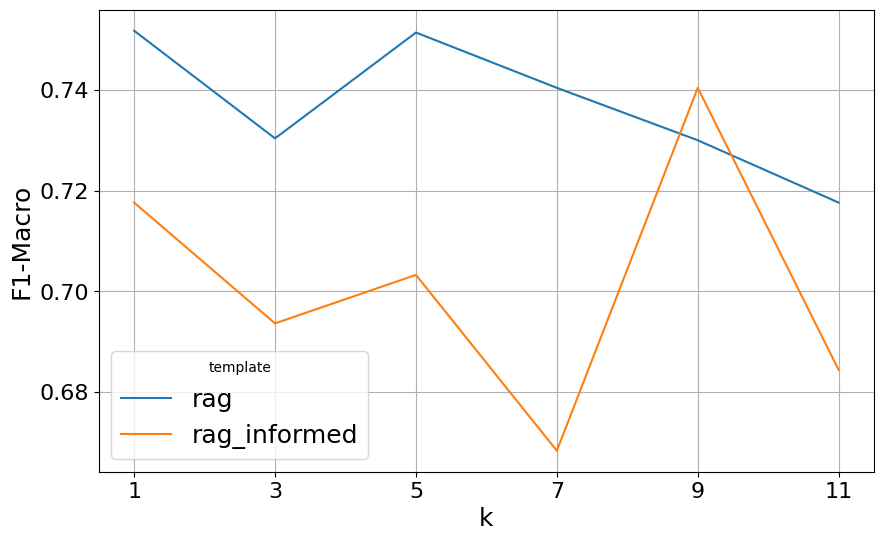

In [ ]:
rag_results = pd.read_csv('RESULTS/rag_db_full.csv').pivot(index='top_k', columns='template', values='avg_f1')
fig,ax = plt.subplots()
rag_results.plot(
    xlabel="k",
    ylabel="F1-Macro",
    grid=True,
    ax = ax
)

# Set the x-ticks to correspond to the values of 'K'
ax.set_xticks(rag_results.index)

# Display the plot
plt.show()

## Sparse Vector Representation


In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")

In [ ]:
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
retrieval_system_sparse = RetrievalSystemSparse(db_full,vectorizer_type = 'bow')

Instantiating BOW vectorizer
Fitting vectorizer and generating sparse representations...
Creating NearestNeighbors model...
Sparse retrieval system created.


In [ ]:
rag_sparse = RAG(retrieval_system = retrieval_system_sparse, model_name = 'mistral')

In [ ]:
k_range = range(1,12,2)
sparse_results = {}
for k in k_range:
  predictions = test_rag(
      rag = rag_sparse,
      queries = query_downsampled,
      top_k = k,
      prompt_template = rag_template,
      example_template = example_template,
      split = False,
  )
  sparse_results[k] = compute_avgf1(query_downsampled['Successful'],predictions)

In [ ]:
sparse_results

1         3         5         7         9         11
1   0.625545  0.668342  0.659586  0.613345  0.551412  0.703254
3   0.625545  0.668342  0.659586  0.613345  0.551412  0.703254
5   0.625545  0.668342  0.659586  0.613345  0.551412  0.703254
7   0.625545  0.668342  0.659586  0.613345  0.551412  0.703254
9   0.625545  0.668342  0.659586  0.613345  0.551412  0.703254
11  0.625545  0.668342  0.659586  0.613345  0.551412  0.703254

## Downsampling DB
Idea: since we observe that as k increases as the performance downgrades, we argue that the negative points shadows the positive ones.

We can model our RAG system as an augmented-knn where the model domain-knowledge can favor a class over the other, even if the pure count favors the other.

However, as k increase, as more the negative examples retrieved are in the neighborhood, due to their higher density (99 negatives for each positive).

Therefore, we decide to wipe out examples to stick on positives, cleaning up positive neighborhood, to enhance their retrieval.

In [ ]:
# 1:1 equal proportion
_db_positive = db_full[db_full['Successful']]
_db_negative = db_full[~db_full['Successful']].sample(n= _db_positive.shape[0],random_state = 42)
db_downsampled_1_1 = pd.concat([_db_positive, _db_negative])

In [ ]:
avg_distance = {}
for k in range(1,12,1):
  intra_cluster_distances = []
  # Retrieve top-k according to L2
  for q in _db_positive['Summary']:
    # Compute avg (+) distance from its cluste
    neighborhood = best_encoder(q,top_k=k + 1,upper_bound=None,lower_bound=None,metric='L2-NOT-SCALED',split=False)
    intra_cluster_distances.append(neighborhood[~neighborhood['Successful']]['L2-NOT-SCALED'].to_list())
  intra_cluster_distances_unfold = [ d for cluster in intra_cluster_distances for d in cluster ]
  avg_distance[k] = sum(intra_cluster_distances_unfold) / len(intra_cluster_distances_unfold)

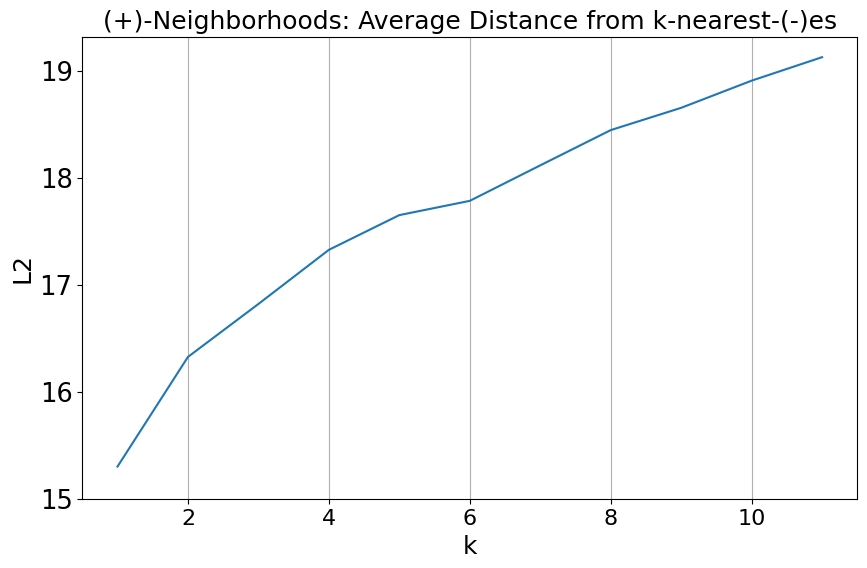

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
x=list(avg_distance.keys())
y=list(avg_distance.values())
ax.plot(x,y)
ax.set_xlabel('k')
ax.set_ylabel('L2')
plt.title("(+)-Neighborhoods: Average Distance from k-nearest-(-)es")
ax.set_yticks(np.arange(int(y[0]),int(y[-1]) + 1))
ax.grid(axis='x')

In [ ]:
avg_distance

{1: 15.3005480940749,
 2: 16.325051535730775,
 3: 16.819700365739244,
 4: 17.325703158836248,
 5: 17.650077148763145,
 6: 17.783379159627422,
 7: 18.114886104544073,
 8: 18.444197258326056,
 9: 18.652542240517114,
 10: 18.90635641540841,
 11: 19.12572754922804}

In [ ]:
threshold = 15.8

In [ ]:
# Collecting points to be dropped from db
to_drop = []
for q in _db_positive['Summary']:
  # Retrieve neighborhood to r
  neighborhood = best_encoder(q,top_k=db_full.shape[0],upper_bound=threshold,lower_bound=None,metric='L2-NOT-SCALED',split=True)
  # Consider only negative points
  neighborhood_neg = neighborhood[~neighborhood['Successful']]
  # Collect their ids
  to_drop.extend(neighborhood_neg['ID'])
# Showing them
to_drop= set(to_drop)
print(f"#Removed objects= {len(to_drop)}")
print(to_drop)

#Removed objects= 518
{'ID000440', 'ID003006', 'ID003374', 'ID001200', 'ID006096', 'ID002620', 'ID000312', 'ID001582', 'ID004280', 'ID001486', 'ID001968', 'ID002744', 'ID003071', 'ID001215', 'ID002872', 'ID007678', 'ID000432', 'ID009904', 'ID011066', 'ID001342', 'ID002680', 'ID002470', 'ID006450', 'ID010608', 'ID000751', 'ID010751', 'ID004263', 'ID002896', 'ID006567', 'ID004704', 'ID004920', 'ID006847', 'ID011327', 'ID000184', 'ID003358', 'ID004927', 'ID007359', 'ID011064', 'ID010943', 'ID002208', 'ID001376', 'ID003128', 'ID004286', 'ID009208', 'ID000800', 'ID003007', 'ID001440', 'ID010528', 'ID003631', 'ID002672', 'ID001256', 'ID000047', 'ID005406', 'ID000879', 'ID001718', 'ID006815', 'ID005690', 'ID011487', 'ID005024', 'ID007088', 'ID005304', 'ID005167', 'ID006071', 'ID002556', 'ID011576', 'ID001936', 'ID008764', 'ID003070', 'ID004168', 'ID000376', 'ID001148', 'ID000248', 'ID009504', 'ID001816', 'ID006775', 'ID010941', 'ID009024', 'ID004671', 'ID011584', 'ID004797', 'ID001584', 'ID00

In [ ]:
db_expl = db_full[~db_full['ID'].isin(to_drop)].copy()

In [ ]:
db_expl.to_csv("DBs/db_expl.csv",index = False)

In [ ]:
db_downsampled_1_1.to_csv("DBs/db_1:1.csv")

In [ ]:
# Precision@K def
def precision_at_k(query_df : pd.DataFrame, retrieval_system : RetrievalSystem, k : int, metric : str = 'IP'):
  n_relevant = 0
  for _, q in query_df.iterrows():
    # Retrieve
    neighborhood = retrieval_system.retrieve(
        query = q[retrieval_system._summary_name],
        top_k = k,
        split = False,
        upper_bound = None,
        lower_bound = None,
        metric = metric,
    )

    # Get Neighborhood labels
    labels = neighborhood['Successful'].values
    relevant_value = q['Successful']

    # Count Relevant Items
    n_relevant += sum(relevant_value == l for l in labels)

  return n_relevant / (k*query_df.shape[0])

In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
db_11 = pd.read_csv("DBs/db_1:1.csv")
db_expl = pd.read_csv("DBs/db_expl.csv")
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
best_encoder_name = 'bert-base-nli-mean-tokens'

In [ ]:
candidates = {
    name : RetrievalSystem(db,best_encoder_name) for name,db in [('db_full',db_full),('db_1:1',db_11),("db_expl",db_expl)]
}

Instantiating embedding model: bert-base-nli-mean-tokens


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.
Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
candidates['db_full'].db.shape

(9523, 16)

In [ ]:
candidates['db_1:1'].db.shape

(202, 17)

In [ ]:
candidates['db_expl'].db.shape

(9016, 16)

In [ ]:
precisions = {
    db_name : [] for db_name in candidates
}

# Iterate over k values and retrieval systems to compute precisions
for k in k_range:
    for _db_name,_rs in candidates.items():
        # Compute precision for "overall"
        precision_overall = precision_at_k(query_full, _rs, k=k)
        precisions[_db_name].append(precision_overall)

# Create DataFrame for overall precisions
precision_viz_overall = pd.DataFrame(precisions, index=k_range)
precision_viz_overall.to_csv('RESULTS/precision_viz_overall.csv')

In [ ]:
precision_viz_overall

db_full    db_1:1   db_expl
1   0.996535  0.766565  0.967132
3   0.982919  0.724632  0.955686
5   0.979775  0.702342  0.951780
7   0.977978  0.687118  0.950781
9   0.977038  0.677669  0.951241
11  0.976564  0.668764  0.951219

In [ ]:
k_range = range(1,12,2)

In [ ]:
query_full[query_full['Successful']].shape

(25, 16)

In [ ]:
precisions_pos = {
    db_name : [] for db_name in candidates
}
for k in k_range:
    for _db_name,_rs in candidates.items():
        precision_pos = precision_at_k(query_full[query_full['Successful']], _rs, k=k)
        precisions_pos[_db_name].append(precision_pos)

In [ ]:
precision_viz_pos = pd.DataFrame(precisions_pos, index = k_range)
precision_viz_pos.to_csv("RESULTS/precision_pos.csv")

In [ ]:
precision_viz_pos

db_full    db_1:1   db_expl
1   0.360000  0.800000  0.560000
3   0.253333  0.813333  0.546667
5   0.216000  0.808000  0.536000
7   0.228571  0.800000  0.531429
9   0.217778  0.813333  0.506667
11  0.210909  0.825455  0.490909

## Embeddings visualization

In [ ]:
db_expl = pd.read_csv("DBs/db_expl.csv")

In [ ]:
sbert_db_expl = RetrievalSystem(db_expl,"bert-base-nli-mean-tokens")

Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
sbert_expl_tsne = compute_tsne(sbert_db_expl.embeddings['not_scaled'])

In [ ]:
sbert_expl_tsne

array([[ 28.52595  , -29.978592 ],
       [ 24.45513  ,  44.364223 ],
       [-74.21939  ,  -9.702891 ],
       ...,
       [-45.793526 ,   1.2020476],
       [-63.455334 , -10.534315 ],
       [ 31.682928 , -14.293461 ]], dtype=float32)

In [ ]:
# Simplifying presentation
db_full.loc[
    db_full['Damage_Type'] == 'Visible deformation in axial direction',
    'Damage_Type'
] = 'Axial deformation'

In [ ]:
import matplotlib.pyplot as plt
import string

def plot_tsne(ax, tsne, db, color_feature, marker_feature, title, marker_label, hide_y_ticks=False):
    # Aggiungiamo le coordinate t-SNE al DataFrame
    db['x'], db['y'] = tsne[:, 0], tsne[:, 1]

    # Generate color map
    unique_colors = db[color_feature].unique()
    color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}

    # Plot
    for marker_value in [True, False]:
        marker = '*' if marker_value else 'o'
        marker_size = 250 if marker_value else 8  # Larger stars for emphasis
        alpha = 1 if marker_value else 0.6  # Stars more solid
        edgecolor = 'black'
        linewidth = 1 if marker_value else 0
        subset = db[db[marker_feature] == marker_value]
        ax.scatter(
            subset['x'], subset['y'], c=subset[color_feature].map(color_map),
            marker=marker, edgecolor=edgecolor, alpha=alpha, s=marker_size, linewidth=linewidth
        )
    ax.set_title(title, fontsize=30)
    ax.grid(True)

    # Add custom legend for markers inside subplot
    ax.scatter([], [], marker='*', s=100, color='black', label=marker_label[True])
    ax.scatter([], [], marker='o', s=50, color='black', label=marker_label[False])
    ax.legend(loc='best', fontsize=16.5, frameon=True, handletextpad=0.1)

    # Remove y-ticks and y-labels if required
    if hide_y_ticks:
        ax.tick_params(left=False, labelleft=False)

    # Reduce tick size
    ax.tick_params(axis='both', labelsize=10, width=1.5)

def plot_multiple_tsne(tsne_list, db_list, color_feature, marker_feature, marker_label, titles=None, f_title = "t-SNEs.pdf"):
    num_plots = len(tsne_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(29.5, 6.5), gridspec_kw={'wspace': 0.05})

    if num_plots == 1:
        axes = [axes]  # To handle single plot case

    # Generate titles with (a), (b), (c)...
    letters = string.ascii_lowercase[:num_plots]
    formatted_titles = [f"({letters[i]}) {titles[i]}" if titles else f"({letters[i]}) t-SNE {i+1}" for i in range(num_plots)]

    # Plot each t-SNE in its subplot
    for i, (tsne, db, ax) in enumerate(zip(tsne_list, db_list, axes)):
        hide_y_ticks = (i != 0)  # Hide y-ticks for all but the first plot
        plot_tsne(ax, tsne, db, color_feature, marker_feature, formatted_titles[i], marker_label, hide_y_ticks)

    # Generate legend based on the first DataFrame
    unique_colors = db_list[0][color_feature].unique()
    color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[val], markersize=8, label=str(val))
               for val in unique_colors]

    # Global legend with bold text and reduced space between values
    fig.legend(handles=handles, loc='lower center', ncol=len(unique_colors), bbox_to_anchor=(0.5, -0.037), fontsize=20, columnspacing=0.2, handletextpad=0.01)

    # Save the figure as a PDF
    plt.savefig(f_title, format="pdf", bbox_inches="tight")

    plt.show()


<ipython-input-30-7c8939750114>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-30-7c8939750114>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-30-7c8939750114>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


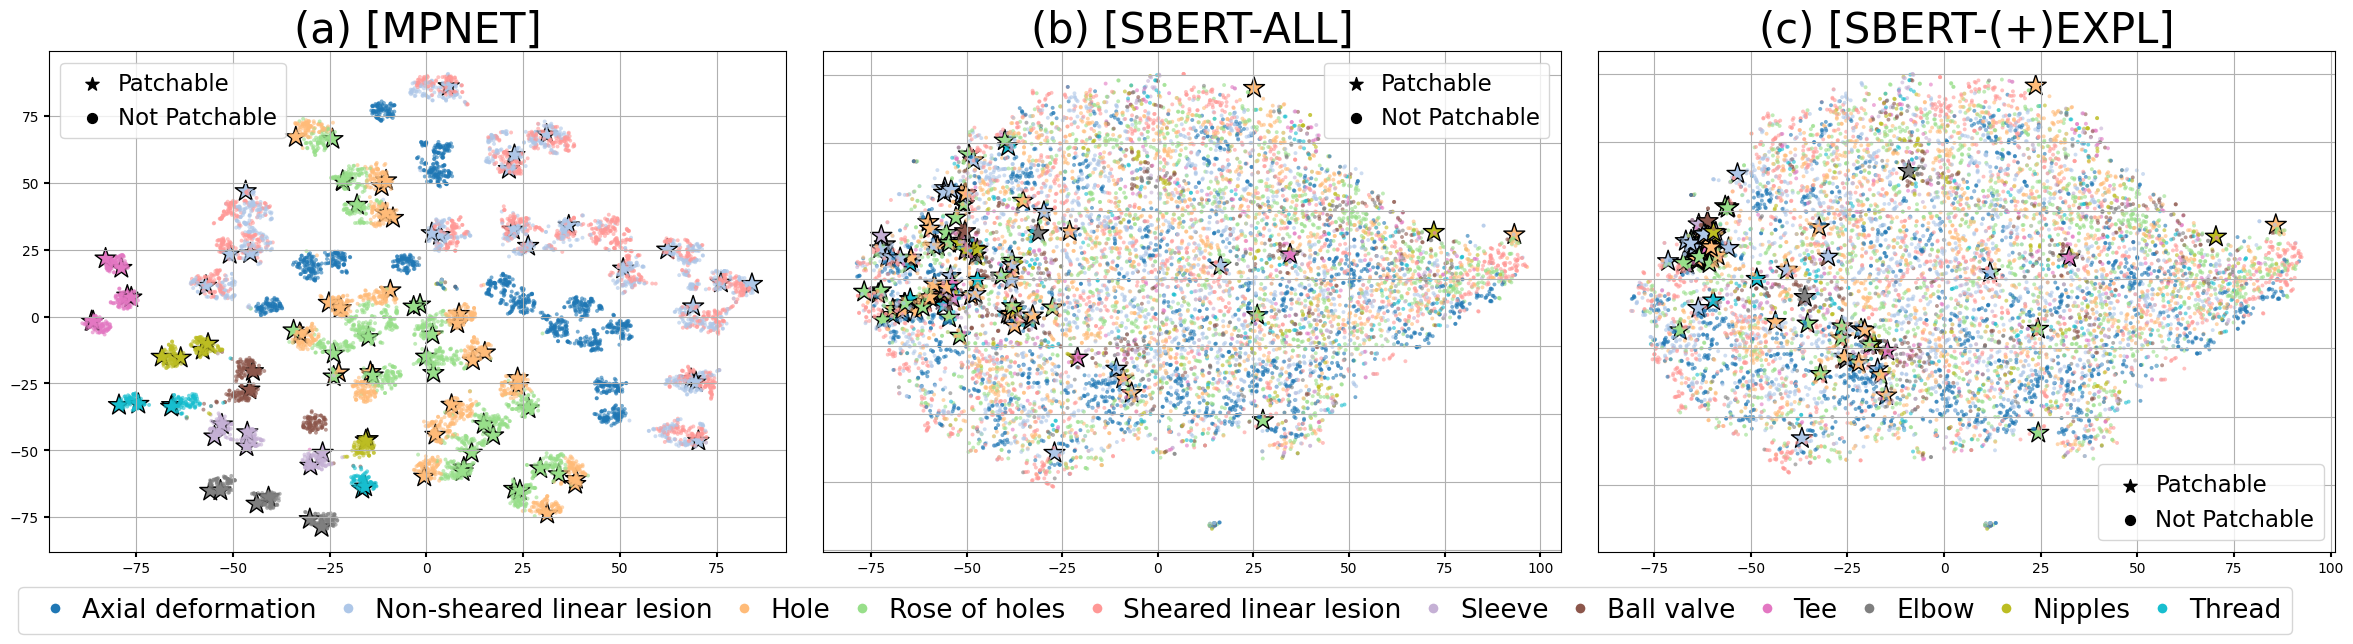

In [ ]:
plot_multiple_tsne(
    [mpnet_tsne,sbert_tsne, sbert_expl_tsne],
    [db_full,db_full,db_expl],
    color_feature = "Damage_Type",
    marker_feature = "Successful",
    marker_label = {True : "Patchable", False: "Not Patchable"},
    titles = ["[MPNET]", "[SBERT-ALL]", "[SBERT-(+)EXPL]"]
)

<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


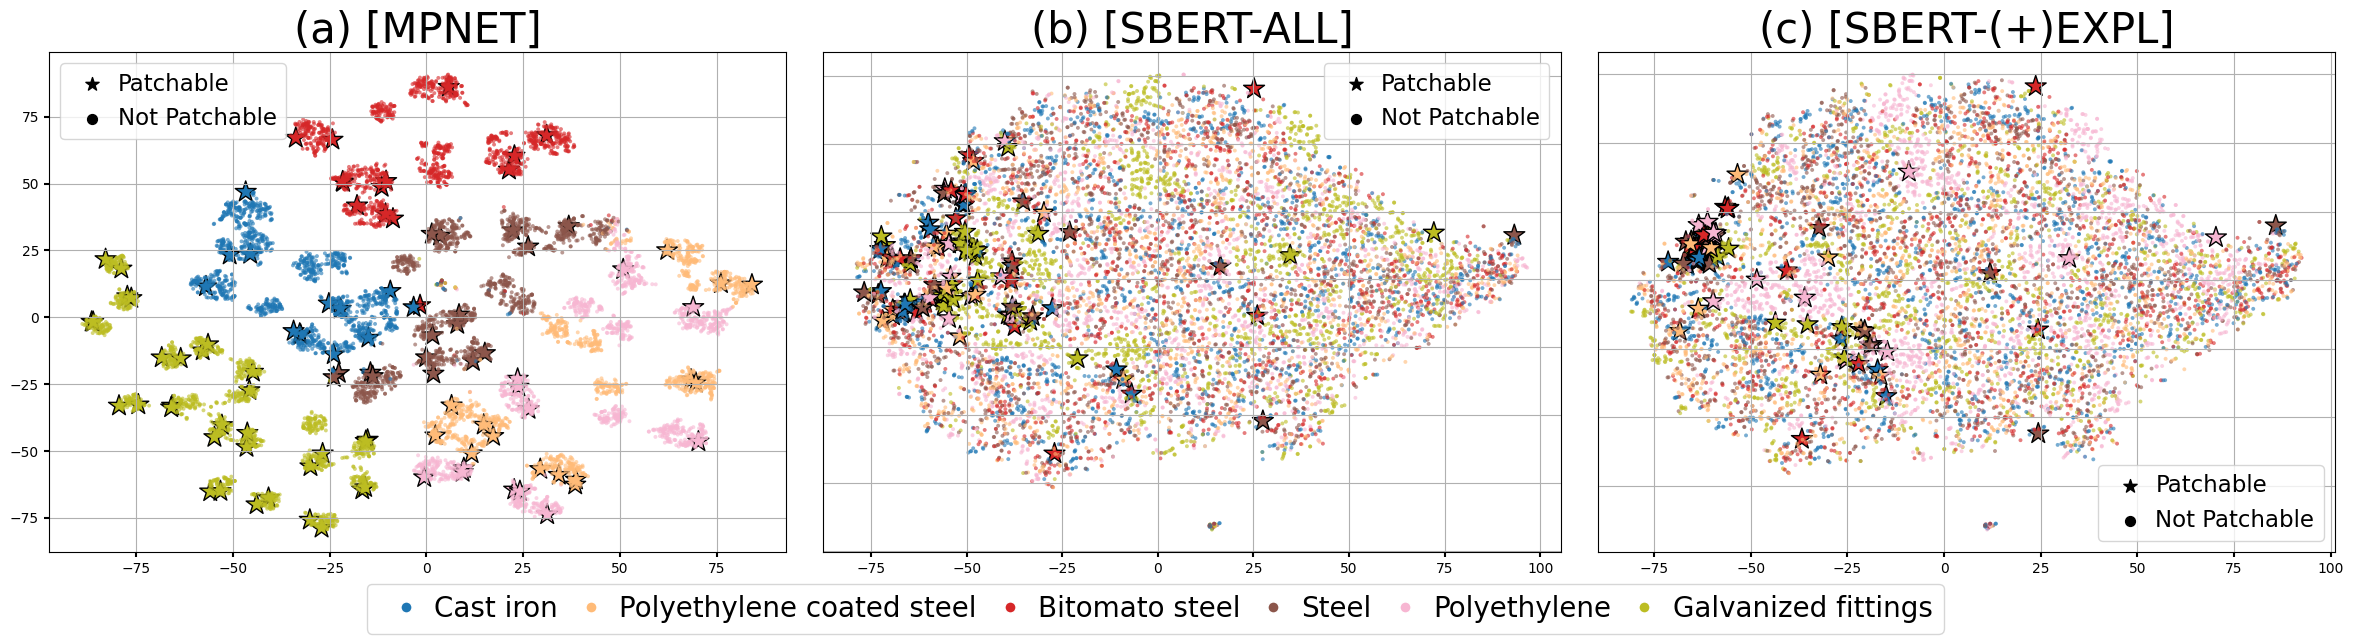

In [ ]:
plot_multiple_tsne(
    [mpnet_tsne,sbert_tsne, sbert_expl_tsne],
    [db_full,db_full,db_expl],
    color_feature = "Pipe_Material",
    marker_feature = "Successful",
    marker_label = {True : "Patchable", False: "Not Patchable"},
    titles = ["[MPNET]", "[SBERT-ALL]", "[SBERT-(+)EXPL]"],
    f_title = "t-SNEs-Material.pdf"
)

<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {value: plt.cm.get_cmap("tab20")(i / len(unique_colors)) for i, value in enumerate(unique_colors)}
<ipython-input-38-12cc7503194b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


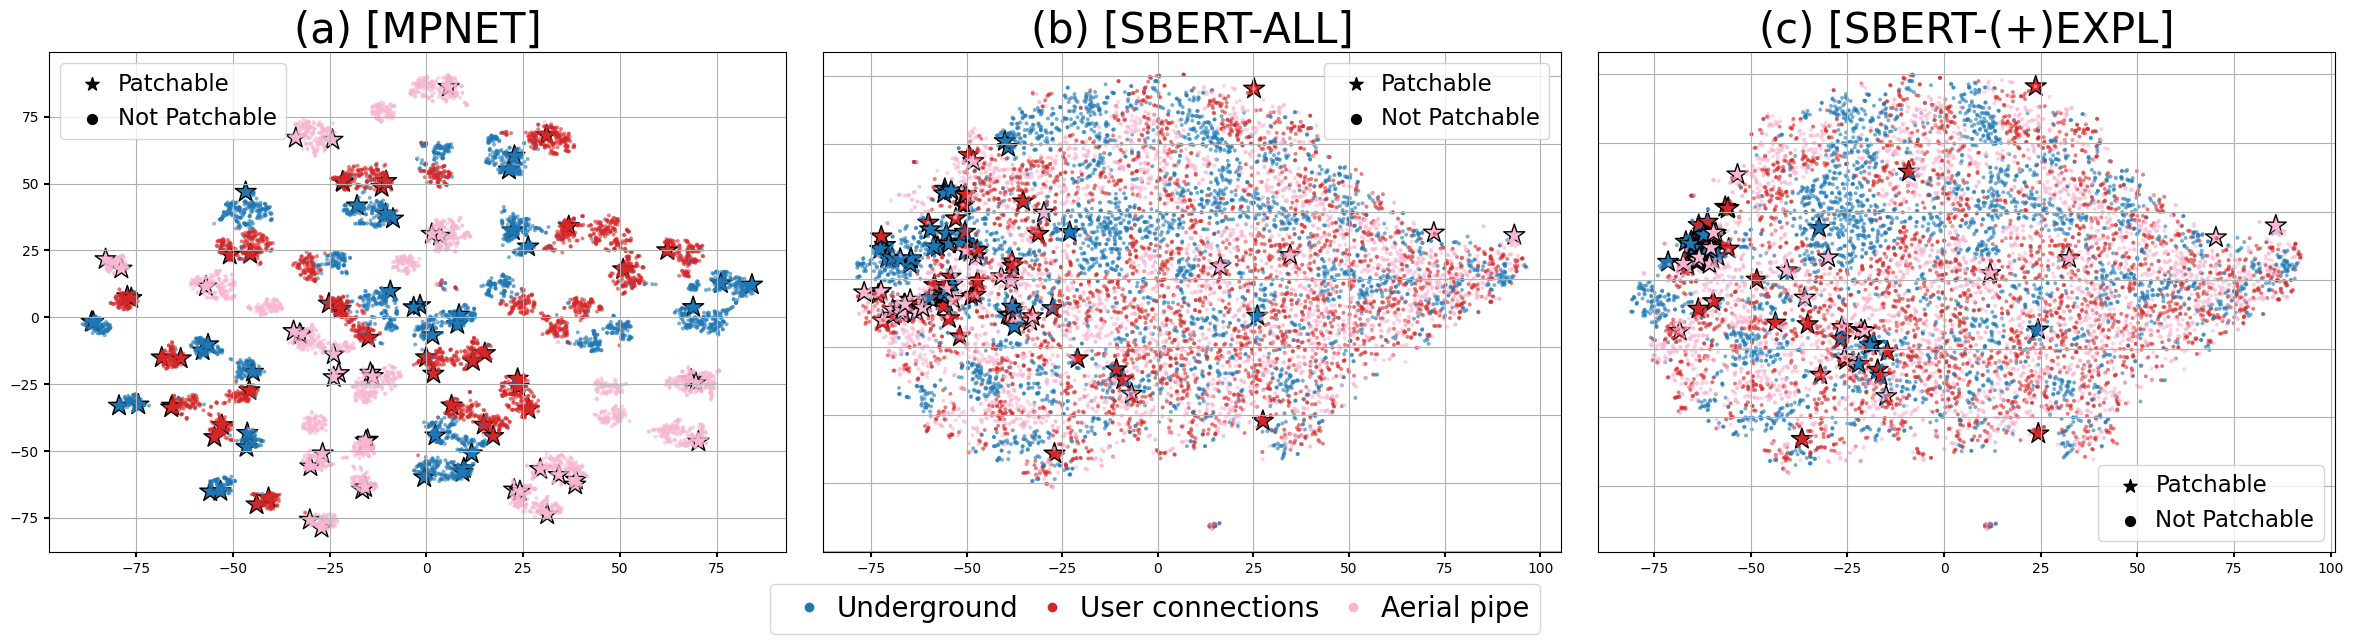

In [ ]:
plot_multiple_tsne(
    [mpnet_tsne,sbert_tsne, sbert_expl_tsne],
    [db_full,db_full,db_expl],
    color_feature = "Pipe_Exposure",
    marker_feature = "Successful",
    marker_label = {True : "Patchable", False: "Not Patchable"},
    titles = ["[MPNET]", "[SBERT-ALL]", "[SBERT-(+)EXPL]"],
    f_title = "t-SNEs-Exposure.pdf"
)

## Downsampled vs Full-DB

In [ ]:
best_decoder_name = 'mistral'

In [ ]:
k = 5 # best performances for full_db

In [ ]:
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
results = {db_name : [] for db_name in candidates if db_name != 'db_full'}
# For each system
for db_name in results:
    # For both templates
    _results = {}
    for template_name,template in [('rag', rag_template), ('rag_informed', rag_informed_template)]:
      # Compute predictions
        predictions = test_rag(
            rag=RAG(candidates[db_name],best_decoder_name),
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )

        # Score
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)

        # Save
        _results[template_name] = avg_f1
    results[db_name] = _results

# Create DataFrame and save results
rag_results_downsampled = pd.DataFrame(results)
rag_results_downsampled.to_csv("RESULTS/rag_@5_db_downsampled.csv", index=False)

In [ ]:
rag_results_downsampled

db_1:1   db_expl
rag           0.785518  0.817436
rag_informed  0.773551  0.813512

In [ ]:
# Test the best model for all ks as we did for full_db
best_encoder_name = "db_expl"
results_expl = []
rag = RAG(candidates[best_encoder_name],best_decoder_name)
# Test RAG under both templates
for k in k_range:
    for template in [rag_template, rag_informed_template]:
        predictions = test_rag(
            rag=rag,
            queries=query_downsampled,
            top_k=k,
            prompt_template=template,
            example_template=example_template,
            split = False
        )
        avg_f1 = compute_avgf1(query_downsampled['Successful'], predictions)
        results_expl.append({
            'template': 'rag' if template == rag_template else 'rag_informed',
            'top_k': k,
            'avg_f1': avg_f1
        })

# Create DataFrame and save results_expl
rag_results_expl = pd.DataFrame(results_expl)

# Pivot per ottenere template come colonne, top_k come indici e avg_f1 come entry
rag_results_expl = rag_results_expl.pivot(index='top_k', columns='template', values='avg_f1')

rag_results_expl.to_csv("RESULTS/rag_db_expl.csv", index=False)
rag_results_expl

template       rag  rag_informed
top_k                           
1         0.839538      0.779347
3         0.793729      0.829682
5         0.806929      0.813512
7         0.796748      0.813512
9         0.871081      0.806929
11        0.850949      0.829682

### Graphs and tabels

In [ ]:
# Load results
zero_shot = 0.68
few_shot =

# Few Shot
We use the same template as rag but fixing with constant examples.

In [ ]:
# Randomly sampling a couple of
examples_random_df = pd.concat([
    db_full[db_full['Successful']].sample(n=2),
    db_full[~db_full['Successful']].sample(n=2)
])[['Successful', 'Summary']]
examples_random_df[['Successful','Summary']]

Successful                                            Summary
977         True  A hole has developed in this cast iron undergr...
5532        True  A galvanized nipple fault has occurred in an a...
3455       False  Aerial galvanized pipe nipple damage occurred ...
487        False  A sheared linear lesion has occurred in the bi...

In [ ]:
# Create examples text
examples = "\n".join(
    [ example_template.format(
        description = x['Summary'],
        label = "YES" if x['Successful'] else "NO",
        i = index + 1
    ) for index, (_,x) in enumerate(examples_random_df.iterrows())]
)

In [ ]:
prompt = ChatPromptTemplate.from_template(rag_template)
chain = prompt | OllamaLLM(model='mistral')
def generate(x : pd.Series):
  return chain.invoke({
      'description': x['Summary'],
      'examples' : examples,
  })

def classify(x : pd.Series):
  return RAG._normalize(generate(x))

In [ ]:
# Predict
predictions = query_downsampled.apply(classify,axis = 1)

# Score
avg_f1 = compute_avgf1(query_downsampled['Successful'].to_list(),predictions.to_list())

print(avg_f1)

0.8135123614663257


In [ ]:
# Positive few shot
# Randomly sampling a couple of
examples_random_df = pd.concat([
    db_full[db_full['Successful']].sample(n=4),
])[['Successful', 'Summary']]

examples = "\n".join(
    [ example_template.format(
        description = x['Summary'],
        label = "YES" if x['Successful'] else "NO",
        i = index + 1
    ) for index, (_,x) in enumerate(examples_random_df.iterrows())]
)

# Predict
predictions_pos = query_downsampled.apply(classify,axis = 1)

# Score
avg_f1_pos = compute_avgf1(query_downsampled['Successful'].to_list(),predictions_pos.to_list())

print(avg_f1_pos)

0.6386009449263099


In [ ]:
db_full = pd.read_csv("DBs/db_full.csv")
query_downsampled = pd.read_csv("QUERIES/query_downsampled_with_explanation.csv")

In [ ]:
import pandas as pd
from pathlib import Path

# Define function to generate examples based on k shots
def generate_examples(db_full, k):
    # Calculate the number of positives and negatives
    num_positives = (k + 1) // 2
    num_negatives = k - num_positives

    # Sample the positive and negative examples
    examples_random_df = pd.concat([
        db_full[db_full['Successful']].sample(n=num_positives),
        db_full[~db_full['Successful']].sample(n=num_negatives)
    ])[['Successful', 'Summary']]

    return "\n".join(
        [example_template.format(
            description=x['Summary'],
            label="YES" if x['Successful'] else "NO",
            i=index + 1
        ) for index, (_, x) in enumerate(examples_random_df.iterrows())]
    )


# Define function for classification
def classify_with_k(x, k, db_full):
    examples = generate_examples(db_full, k)
    return RAG._normalize(chain.invoke({
        'description': x['Summary'],
        'examples': examples,
    }))

# Run experiments for k in {1, 3, 5, 7, 9, 11}
k_values = range(1, 12, 2)
results = []

for k in k_values:
    predictions = query_downsampled.apply(lambda x: classify_with_k(x, k, db_full), axis=1)
    avg_f1 = compute_avgf1(query_downsampled['Successful'].to_list(), predictions.to_list())
    results.append({'k': k, 'avg_f1': avg_f1})

# Save results to CSV
few_shot_results = pd.DataFrame(results)
few_shot_results.to_csv("RESULTS/few_shot.csv", index=False)

In [ ]:
few_shot_results = pd.read_csv("RESULTS/few_shot.csv")
few_shot_results

k  avg_f1
0   1    0.73
1   3    0.73
2   5    0.76
3   7    0.73
4   9    0.71
5  11    0.62

In [ ]:
rag_results = pd.read_csv("RESULTS/rag_db_full.csv").pivot(index='top_k', columns='template', values='avg_f1')
rag_results

template  rag  rag_informed
top_k                      
1        0.75          0.72
3        0.73          0.69
5        0.75          0.70
7        0.74          0.67
9        0.73          0.74
11       0.72          0.68

In [ ]:
rag_expl_results = pd.read_csv('RESULTS/rag_db_expl.csv')
rag_expl_results.index = [i for i in range(1,12,2)]
rag_expl_results.rename(columns={"rag" : "RAG_(+)EXPL","rag_informed" : "RAG-I_(+)EXPL"},inplace = True)
systems_results = rag_expl_results.join(rag_results.rename(columns={"rag" : "RAG_ALL","rag_informed" : "RAG-I_ALL"}))
systems_results = systems_results.join(few_shot_results.rename(columns={'avg_f1': 'FEW_SHOT'}).set_index('k'))
systems_results['ZERO-SHOT'] = 0.68
systems_results.index.name = "top_k"

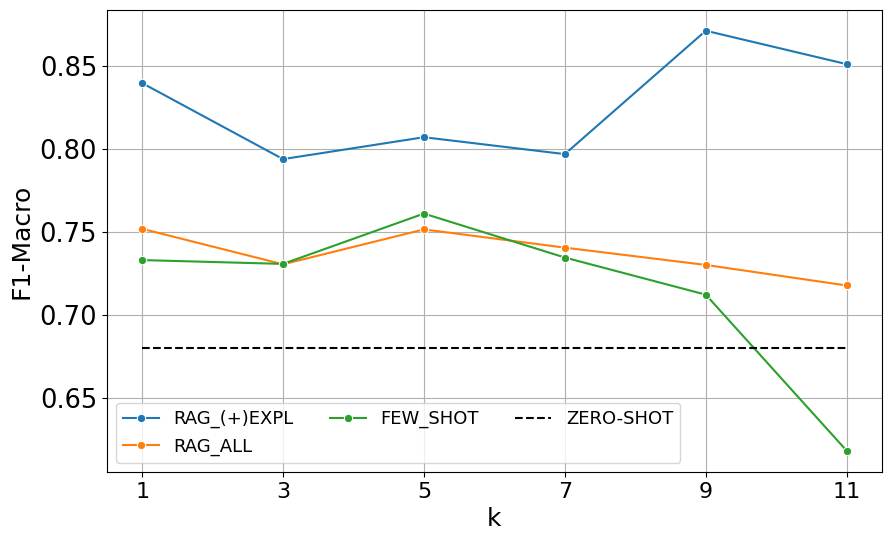

In [ ]:
# Plot each system as a line
sns.lineplot(data=systems_results, x=systems_results.index, y="RAG_(+)EXPL", label="RAG_(+)EXPL", marker='o')
sns.lineplot(data=systems_results, x=systems_results.index, y="RAG_ALL", label="RAG_ALL", marker='o')
sns.lineplot(data=systems_results, x=systems_results.index, y="FEW_SHOT", label="FEW_SHOT", marker='o')

# Plot Zero-Shot with dashed line
plt.plot(systems_results.index, systems_results['ZERO-SHOT'], label="ZERO-SHOT", linestyle='--', color='black')

# Set labels and title
plt.xlabel('k')
plt.ylabel('F1-Macro')
plt.grid()
plt.legend(loc='best', fontsize = 13,ncols = 3)
plt.xticks(rag_results.index)

plt.savefig("RESULTS/rag_results.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
rag_effect = {
    "zero-shot": 0.68,
    "few-shot": 0.76,
    "RAG": 0.87
}

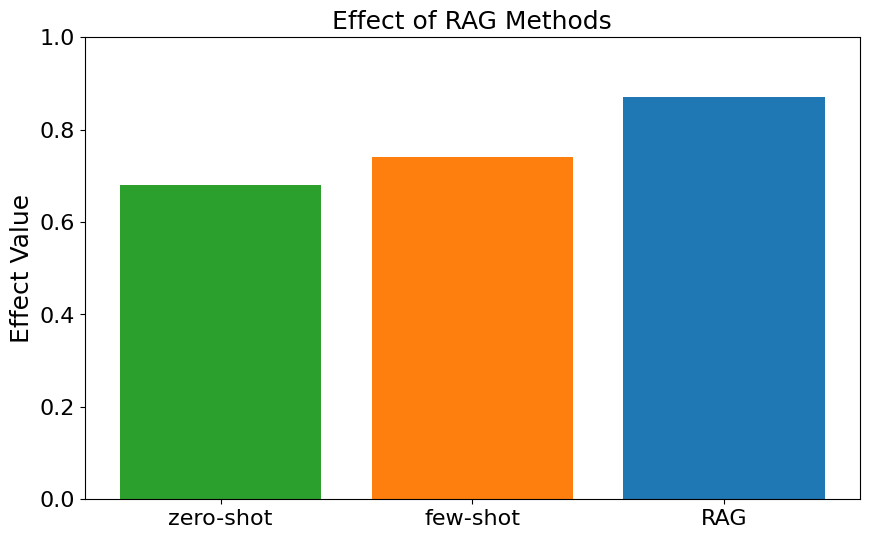

In [ ]:
# Data
rag_effect = {
    "zero-shot": 0.68,
    "few-shot": 0.74,
    "RAG": 0.87
}

palette = sns.color_palette("tab10")

# Calculate the percentage increases
categories = list(rag_effect.keys())
values = list(rag_effect.values())
percentage_leaps = [0] + [((values[i] - values[i-1]) / values[i-1]) * 100 for i in range(1, len(values))]

# Plot
fig, ax = plt.subplots()

bars = ax.bar(categories, values, color=[palette[2], palette[1], palette[0]])


# Labels and Title
ax.set_ylabel('Effect Value')
ax.set_title('Effect of RAG Methods')
plt.ylim(0, 1)  # Y-axis from 0 to 1 for percentage

# Show plot
plt.show()


# Free-Text Generation
In a rel-world scenario, it's more likely a gasfitter looking for an anwser and description.
In this section:
- We show how a prompt looks like before being feed into Mistral
- We show a free-text model answer, by simply removing the constraint from the prompt.

In [ ]:
rag_template_free_text = """
You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "{description}"

Here some examples:
{examples}

Task:
1. Analyze the similarities and differences between the query and the retrieved cases.
2. Based on your analysis, answer by selecting **one and only one** among the following two labels:
  - "YES" if the damage can be repaired by patches;
  - "NO" if the damage cannot be repaired by patches.

### Answer:
"""

In [ ]:
query_full = pd.read_csv("QUERIES/query_full.csv")

In [ ]:
db_expl = pd.read_csv("DBs/db_expl.csv")

In [ ]:
q = query_full.iloc[0]['Summary']
print(q)

A visible deformation in the axial direction, caused by strong corrosion in Bitomato steel, has occurred underground and at high pressure within the pipe. The presence of valves nearby and ribs on the pipe wall suggest that this injury is not due to external factors such as branch damage or poor coating but rather due to internal corrosive forces. Even though the pipe is not covered by a wall, its location beneath the surface makes it more susceptible to corrosion, leading to the visible deformation observed.


In [ ]:
rs = RetrievalSystem(db_expl,'bert-base-nli-mean-tokens')

Instantiating embedding model: bert-base-nli-mean-tokens
Generating embeddings
Scaling embeddigs...
Creating indexing for IP
Creating indexing for COS
Creating indexing for L2-NOT-SCALED
Creating indexing for L2-SCALED
System created.


In [ ]:
rag = RAG(rs,'mistral')

In [ ]:
answer = rag.generate(q,rag_template_free_text,example_template,top_k = 9,split = False)
print(answer)

1. The query describes a visible deformation in the axial direction of an underground Bitomato steel pipe due to strong corrosion and high pressure. The presence of valves nearby and ribs on the pipe wall suggest that this injury is not due to external factors such as branch damage or poor coating but rather due to internal corrosive forces. Unlike the examples provided, this description mentions the specific type of steel (Bitomato) and its susceptibility to corrosion due to its location beneath the surface.

2. Based on the analysis, it appears that the damage described in the query is not patchable (NO). The presence of strong corrosion and high pressure within the pipe, as well as the fact that the pipe is not covered by a wall, indicate that this injury may be more severe than just a localized fault. This suggests that the damage might require more extensive repairs beyond simple patching, such as replacing damaged sections of the pipe or reinforcing it to prevent future deformati

In [ ]:
answer = rag.generate(query_full.iloc[-1]['Summary'],rag_template_free_text,example_template,top_k = 9,split = False, print_prompt = True)
print(answer)


You are an expert in gas pipeline damage analysis. Your goal is to classify whether a given damage description is "patchable" (YES) or "not patchable" (NO).

Here is the damage description you need to classify:
- Query: "A polyethylene-coated steel aerial pipe has suffered a hole injury under bad conditions. Although strong corrosion is present, high pressure within the pipe is not an issue. There is no branch near the break and the pipe is not covered by a wall. Fortunately, a valve is located near the break, but there are no ribs present to provide additional support. The injury is characterized by a hole."

Here some examples:
1.) A polyethylene-coated steel pipe has suffered a hole injury at its user connections due to bad conditions. The injury is not caused by strong corrosion, and there is no high pressure in the pipe. The break occurred near a branch connection, and the pipe is covered by a wall. Additionally, a valve is located near the break. There are no ribs present on the

In [ ]:
query_full.iloc[-1]['Successful']

False